# load module to use pipeline process.

In [1]:

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
import time
import pickle
import collections

from utils_vehicles import showImageList

import seaborn as sns

from multiprocessing import Pool
% matplotlib inline

In [3]:
def bin_spatial(img, size=(32, 32)):
    # Create the feature vector
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [4]:

from sklearn.svm import LinearSVC

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    
    img = image.copy()
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    


In [5]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Data preparation process for Sliding Window technique

In [46]:

# parameters setting 
cars = glob.glob('./sample_data/vehicles/**/*.png')
notcars = glob.glob('./sample_data/non-vehicles/**/*.png')


hist_range=(0,256)
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off



In [47]:
    
print(" building feature & models for sliding window")

print("-" * 30)
print(color_space,orient,pix_per_cell,cell_per_block,hog_channel,spatial_size,hist_bins,hist_range)

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

#X_scaler = StandardScaler().fit(X)
#X = X_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
# Apply the scaler to X
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


 building feature & models for sliding window
------------------------------
RGB 9 8 2 ALL (32, 32) 32 (0, 256)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
26.89 Seconds to train SVC...
Test Accuracy of SVC =  0.9794


In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_filtered_boxes(img, labels, color=(0, 255, 0), thick=6):
        # Iterate through all detected cars
        if len(labels) == 0:
            return img

        for car_number in range(1, labels[1]+1):
            #log.debug('car number ' + str(car_number))
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            x_dist = np.max(nonzerox) - np.min(nonzerox)
            y_dist = np.max(nonzeroy) - np.min(nonzeroy)
            #log.debug('distances of x=%d and y=%d'.format(x_dist, y_dist))
            # only draw squares and rectangles - but not too disproportionate
            if x_dist > y_dist * 4 or y_dist > x_dist * 2:
                continue
            cv2.rectangle(img, bbox[0], bbox[1], color, thick)
        # Return the image
        return img


# load test road data

In [13]:

project_images = [ os.path.join("./test_images", "test" + str(r) + ".jpg") for r in range(1,7) ]
imread_op = lambda x:mpimg.imread(x)
p_images = list(map( imread_op, project_images )) 

In [14]:
filenames = [f.split('/')[-1] for f in project_images ]
filenames

['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']

## test slide window and search_window(single_img_features)

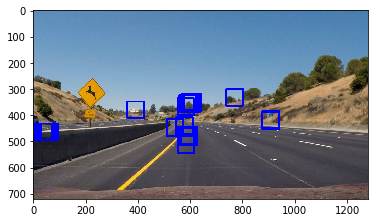

In [48]:


hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

## show sample test image 

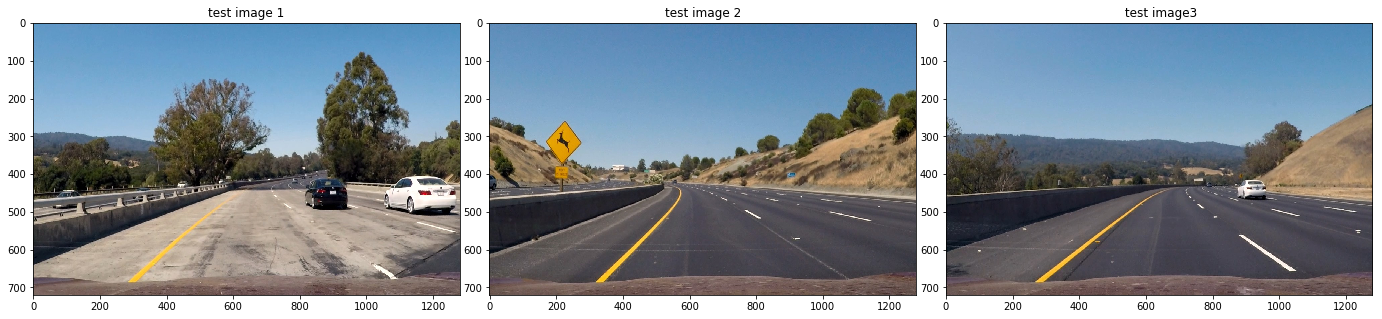

In [19]:
rgb_images = np.asarray([[  p_images[0] ,p_images[1] ,p_images[2] ]] )
rgb_labels = np.asarray([["test image 1","test image 2"," test image3"]])
showImageList(rgb_images, rgb_labels,cols=3, fig_size=(24,5))

## load saved parameters and model parameters from pickle file

***
we avoid to re-train for car / non car images data

In [20]:
ystart, ystop = y_start_stop[0], y_start_stop[1]

In [21]:
print("orient:%s" %  orient)
print("pix_per_cell : %s" % pix_per_cell)
print("cell_per_block : %s" % cell_per_block)
print("spatial_size : " , spatial_size)
print("hist_bins : %s" % hist_bins)
print("y_start_stop : %s" % y_start_stop)

orient:9
pix_per_cell : 8
cell_per_block : 2
spatial_size :  (32, 32)
hist_bins : 32
y_start_stop : [300, 656]


## test whether loaded svc is working well to predict flag based on test image data.

In [22]:
y_test[:10]

array([ 0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.])

In [23]:
svc.predict(X_test[:10])

array([ 1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.])

## display all boxes on test images how box are build table matrix to search object.

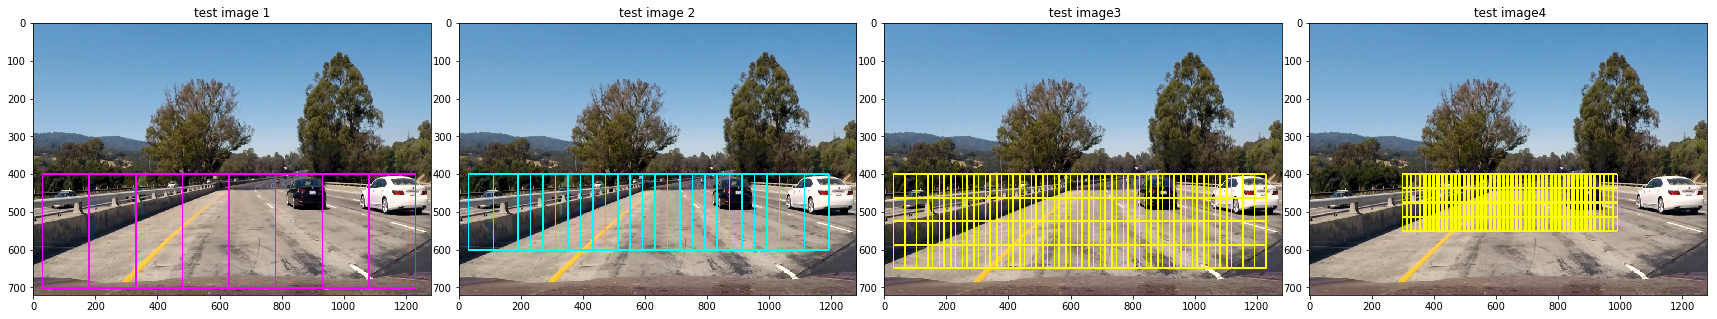

In [56]:

image = p_images[0].copy()
xl_windows = slide_window(
    image, x_start_stop=[30, 1250], y_start_stop=[400, 700],
    xy_window=(300, 300), xy_overlap=(0.5, 0.5))

# large boxes
l_windows = slide_window(
    image, x_start_stop=[30, 1250], y_start_stop=[400, 600],
    xy_window=(200, 200), xy_overlap=(0.6, 0.5))

# medium boxes
m_windows = slide_window(
    image, x_start_stop=[30, 1250], y_start_stop=[400, 650],
    xy_window=(125, 125), xy_overlap=(0.7, 0.5))

# small boxes
s_windows = slide_window(
    image, x_start_stop=[300, 1000], y_start_stop=[400, 550],
    xy_window=(75, 75), xy_overlap=(0.8, 0.5))


windows_final = xl_windows + l_windows + m_windows + s_windows

result_window1 = draw_boxes(image, xl_windows, color=(255, 0, 255), thick=3)
result_window2 = draw_boxes(image, l_windows, color=(0, 255, 255), thick=3)
result_window3 = draw_boxes(image, m_windows, color=(255, 255, 0), thick=3)
result_window4 = draw_boxes(image, s_windows, color=(255, 255, 0), thick=3)

rgb_images = np.asarray([[  result_window1 ,result_window2 ,result_window3, result_window4 ]] )
rgb_labels = np.asarray([["test image 1","test image 2"," test image3", " test image4"]])
showImageList(rgb_images, rgb_labels,cols=4, fig_size=(30,5))

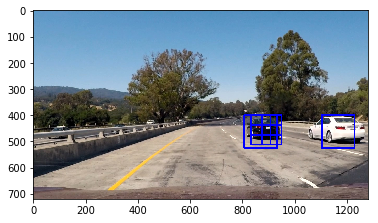

In [58]:
hot_windows = search_windows(image, windows_final, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

In [62]:
image = rand6[0].copy()

def pipeline_test(im, draw = False):
    image = im.copy()
    draw_image = image.copy()
    
    x_start_stops = [ [30, 1250],[30, 1250], [30, 1250], [300, 1250]]
    xy_windows = [300,200,125,75]
    y_start_stops = [[400, 700], [400, 600], [400, 650], [400, 550] ]
    xy_overlaps = [ 0.5,0.6, 0.7, 0.8 ]

    windows_final = []
    for i in range(4):
        windows_part = slide_window(
            image, x_start_stop = x_start_stops[i], y_start_stop = y_start_stops[i],
            xy_window=(xy_windows[i], xy_windows[i]), xy_overlap=(xy_overlaps[i], 0.5))

        windows_final = windows_part + windows_final

    hot_windows_list = search_windows(image, windows_final, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    
    if draw:
        result_window = draw_boxes(draw_image, hot_windows_list, color=(255, 0, 255), thick=3)
        return result_window
    else:
        return hot_windows_list



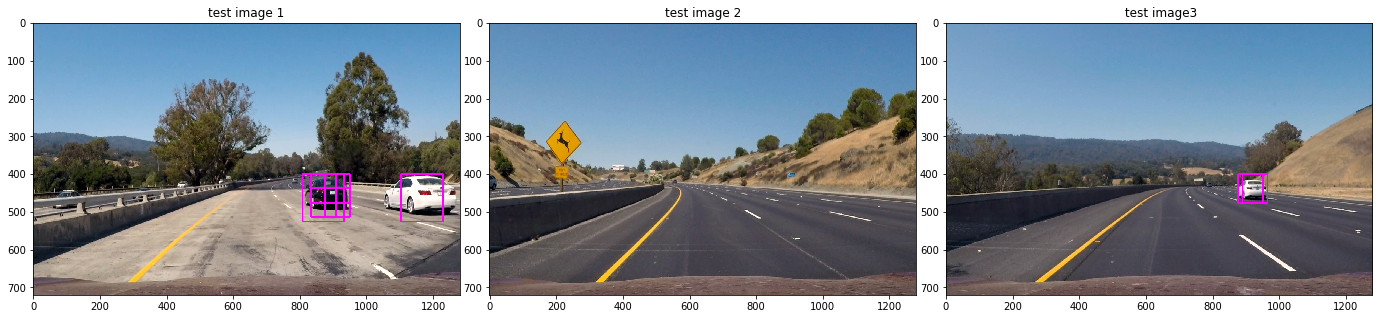

In [54]:
pipeline1_ops = lambda im : pipeline_test(im , draw = True )
result_windows = list( map( pipeline1_ops , p_images[:3] ))
rgb_images = np.asarray([[  result_windows[0] ,result_windows[1] ,result_windows[2] ]] )
rgb_labels = np.asarray([["test image 1","test image 2"," test image3"]])
showImageList(rgb_images, rgb_labels,cols=3, fig_size=(24,5))

## Draw Heatmap to mark Car objects found on image

In [37]:
heatnames = [" heat : on " + f.split('.')[0]  for f in filenames]
detectnames = [" Detect Car : on " + f.split('.')[0] for f in filenames]

print(heatnames)
print(detectnames)

[' heat : on test1', ' heat : on test2', ' heat : on test3', ' heat : on test4', ' heat : on test5', ' heat : on test6']
[' Detect Car : on test1', ' Detect Car : on test2', ' Detect Car : on test3', ' Detect Car : on test4', ' Detect Car : on test5', ' Detect Car : on test6']


2
0
1
2
3
2


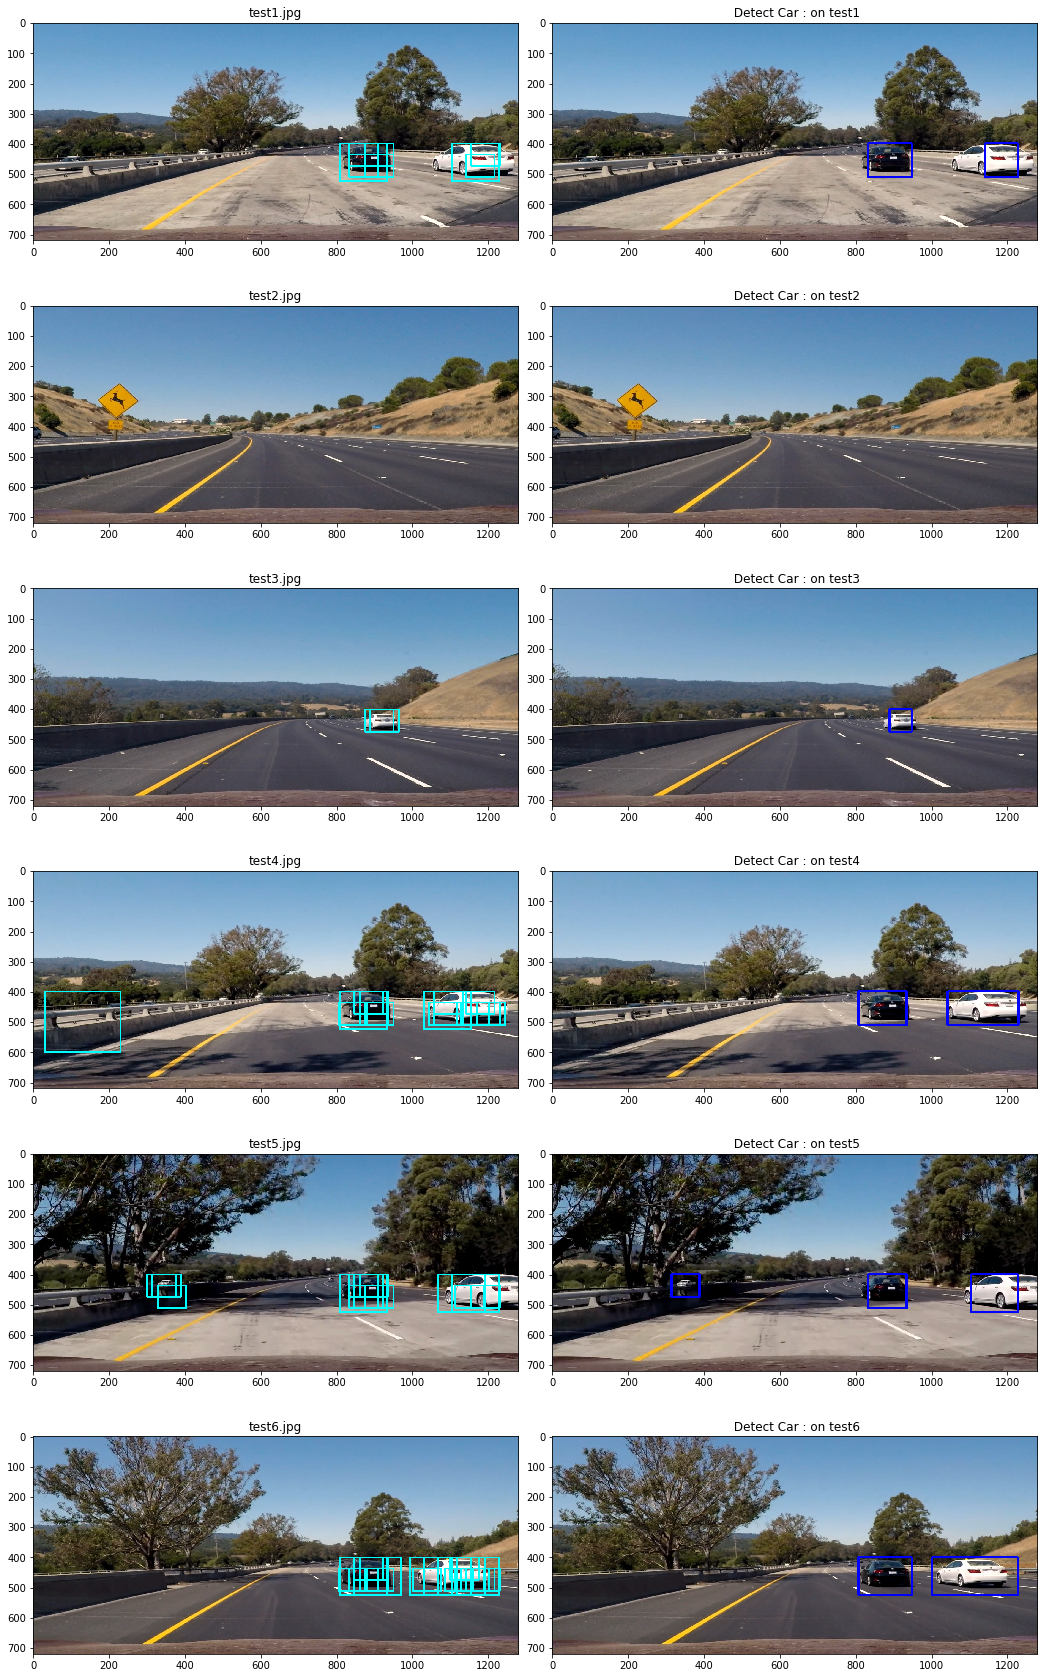

In [63]:



result_windows = []
heatmaps = []
objectDetections = []

for i in range(6):
    
    sample_image = p_images[i].copy()

    tmp_windows = []
    
    box_list = pipeline_test(sample_image, draw = False)
    
    # multi boxes drawn on raw image ...
    result_window = draw_boxes(sample_image, box_list, color=(0, 255, 255), thick=3)
    result_windows.append(result_window)
    
    # Read in image similar to one shown above 
    heat = np.zeros_like(sample_image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    print("Cars found : ", labels[1] + "")
    draw_img = draw_labeled_bboxes(np.copy(sample_image), labels)
        
    heatmaps.append(heatmap)
    objectDetections.append(draw_img)
    
    
images_list =  np.asarray(list( zip( result_windows, objectDetections) ))
images_label =  np.asarray(list( zip(filenames , detectnames ) ))

showImageList(images_list, images_label,cols=2, fig_size=(18,30))    

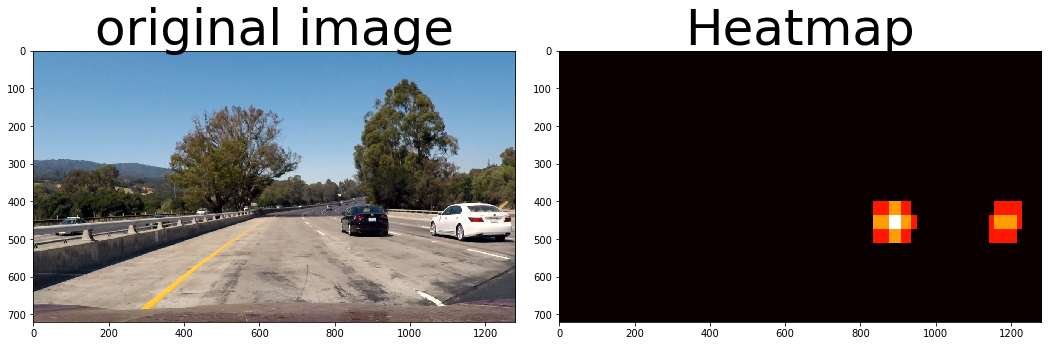

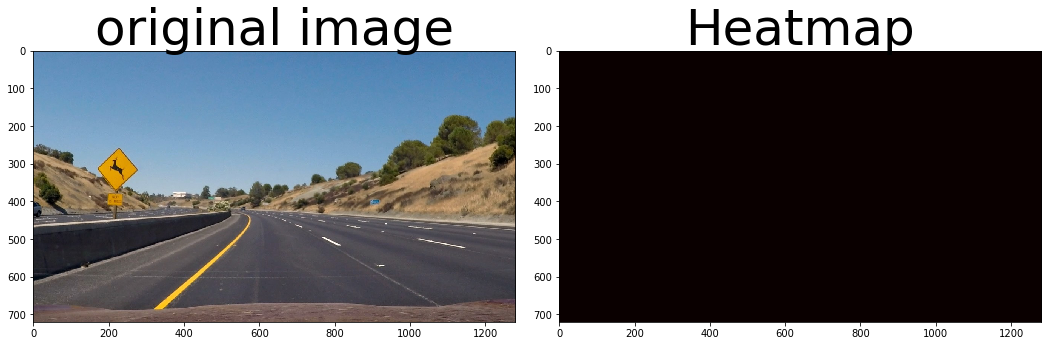

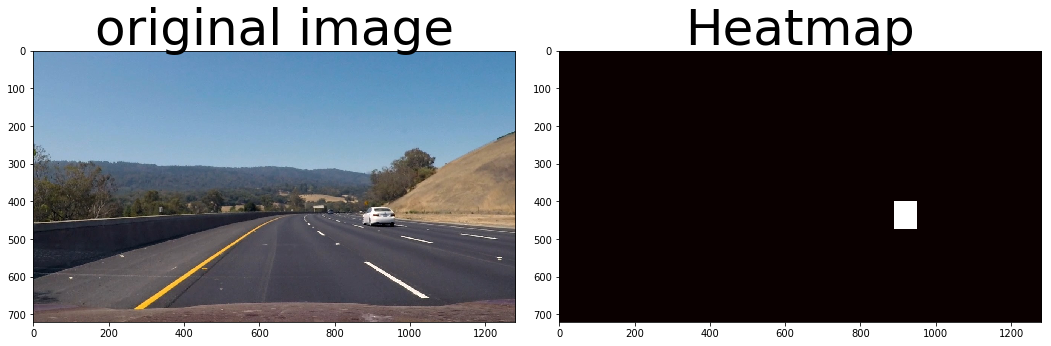

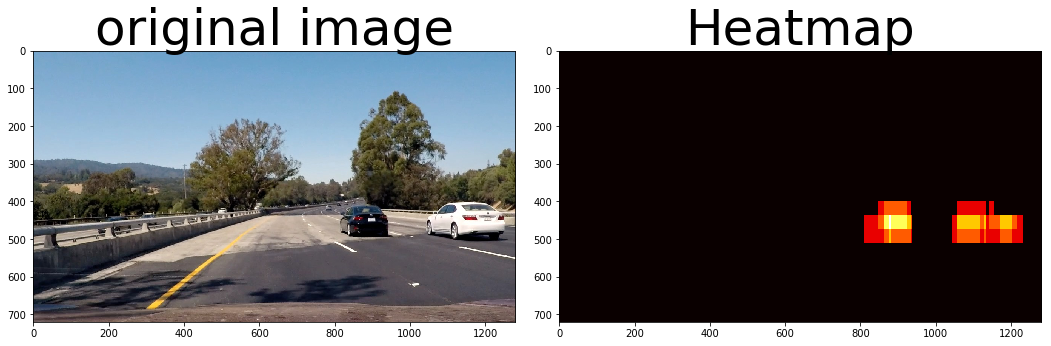

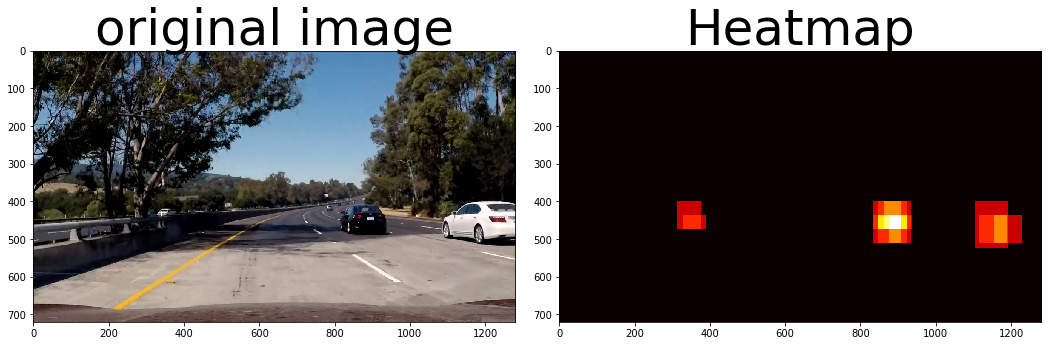

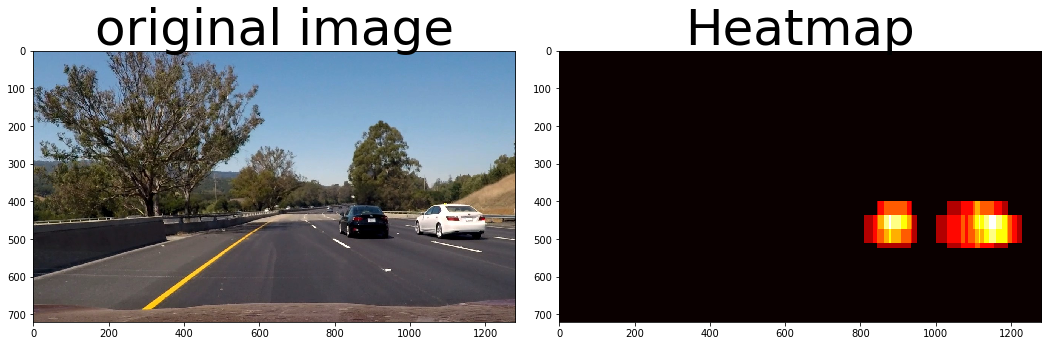

In [64]:
for im, h in zip(p_images,heatmaps):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    f.tight_layout()
    ax1.imshow(im)
    ax1.set_title('original image', fontsize=50)
    ax2.imshow(h,cmap='hot')
    ax2.set_title('Heatmap', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)      

# Final Pipeline process

In [65]:
from collections import deque
class VehicleTracking:
    def __init__(self):
        self.labels_queue = deque()
        self.nlabels = 25
        self.boxes_queue = deque()
        self.nboxes_lists = 40
    def __filter_non_continuous(self, labels):
        label_mesh, label_count = labels
        label_mesh = label_mesh.astype(np.uint8)

        new_mesh = np.zeros_like(label_mesh, dtype=np.uint8)
        for label in range(1, label_count + 1):
            tmp_mesh = np.zeros_like(label_mesh, dtype=np.uint8)
            # regardless of label start with 1
            tmp_mesh[label_mesh == label] = 1
            for prev_lab in self.labels_queue:
                # reset all values to one and start adding
                prev_lab[prev_lab > 0] = 1
                tmp_mesh += prev_lab
            #print('tmp mesh looks like')
            #print(np.max(tmp_mesh))
            #print(np.min(tmp_mesh))
            #print(np.mean(tmp_mesh))
            if np.max(tmp_mesh) > self.nlabels:
                new_mesh[label_mesh == label] = np.max(new_mesh) + 1
        return new_mesh, np.max(new_mesh)

    def remove_false_positives(self, shape, raw_boxes):
        heatmap = np.zeros(shape, dtype=np.float)
        #print(heatmap.shape)
        if len(self.boxes_queue) < self.nboxes_lists:
            self.boxes_queue.append(raw_boxes)
            #print('not enough boxes history ' + str(len(self.boxes_queue)))
            return [], heatmap

        #print('removing false positives')
        self.boxes_queue.popleft()
        self.boxes_queue.append(raw_boxes)

        for boxlist in self.boxes_queue:
            heatmap = add_heat(heatmap, boxlist)

        heatmap = apply_threshold(heatmap, threshold = 40)
        labels = label(heatmap)

        #print(labels[0].shape)
        #print(np.max(labels[0]))
        #print(np.mean(labels[0]))
        #print(np.median(labels[0]))

        self.labels_queue.append(labels[0].astype(np.uint8))
        if len(self.labels_queue) > self.nlabels:
            self.labels_queue.popleft()
        labels = self.__filter_non_continuous(labels)

        if labels[1] > 0:
            print('ended with ' + str(labels[1]) + ' cars')
        return labels, heatmap


# Vehicle Tracking is worked to select rectangle.
vt = VehicleTracking()

In [66]:
def detect_car_pipeline(in_image):


    image = in_image.copy()
    draw_image = np.copy(  image  ) 
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    # extra large boxes
    xl_windows = slide_window(
        image, x_start_stop=[30, 1250], y_start_stop=[400, 700],
        xy_window=(300, 300), xy_overlap=(0.5, 0.5))

    # large boxes
    l_windows = slide_window(
        image, x_start_stop=[30, 1250], y_start_stop=[400, 600],
        xy_window=(200, 200), xy_overlap=(0.6, 0.5))

    # medium boxes
    m_windows = slide_window(
        image, x_start_stop=[30, 1250], y_start_stop=[400, 650],
        xy_window=(125, 125), xy_overlap=(0.7, 0.5))

    # small boxes
    s_windows = slide_window(
        image, x_start_stop=[300, 1000], y_start_stop=[400, 550],
        xy_window=(75, 75), xy_overlap=(0.8, 0.5))


    windows_final = xl_windows + l_windows + m_windows + s_windows

    hot_windows = search_windows(image, windows_final, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    labels, heatmap = vt.remove_false_positives(image.shape[:2],hot_windows )
    
    img_out = draw_filtered_boxes(draw_image, labels, (255, 0, 255), 3)
    #return hot_windows, window_img
    return img_out

In [67]:
## import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [70]:

video_output = 'output_images/project_video_sliding_found3.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(detect_car_pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_sliding_found_v2.mp4
[MoviePy] Writing video output_images/project_video_sliding_found_v2.mp4


  2%|▏         | 25/1261 [00:28<23:51,  1.16s/it]

ended with 1 cars


  2%|▏         | 26/1261 [00:30<23:49,  1.16s/it]

ended with 1 cars


  2%|▏         | 27/1261 [00:31<23:47,  1.16s/it]

ended with 1 cars


  2%|▏         | 28/1261 [00:32<23:45,  1.16s/it]

ended with 1 cars


  2%|▏         | 29/1261 [00:33<23:42,  1.15s/it]

ended with 1 cars


  2%|▏         | 30/1261 [00:34<23:40,  1.15s/it]

ended with 1 cars


 18%|█▊        | 222/1261 [04:30<21:04,  1.22s/it]

ended with 1 cars


 18%|█▊        | 223/1261 [04:31<21:03,  1.22s/it]

ended with 1 cars


 18%|█▊        | 224/1261 [04:32<21:02,  1.22s/it]

ended with 1 cars


 18%|█▊        | 225/1261 [04:33<21:01,  1.22s/it]

ended with 1 cars


 18%|█▊        | 226/1261 [04:35<20:59,  1.22s/it]

ended with 1 cars


 18%|█▊        | 227/1261 [04:36<20:59,  1.22s/it]

ended with 1 cars


 18%|█▊        | 228/1261 [04:37<20:59,  1.22s/it]

ended with 1 cars


 18%|█▊        | 229/1261 [04:39<20:57,  1.22s/it]

ended with 1 cars


 18%|█▊        | 230/1261 [04:40<20:56,  1.22s/it]

ended with 1 cars


 18%|█▊        | 231/1261 [04:41<20:55,  1.22s/it]

ended with 1 cars


 18%|█▊        | 232/1261 [04:42<20:54,  1.22s/it]

ended with 1 cars


 18%|█▊        | 233/1261 [04:44<20:53,  1.22s/it]

ended with 1 cars


 19%|█▊        | 234/1261 [04:45<20:51,  1.22s/it]

ended with 1 cars


 19%|█▊        | 235/1261 [04:46<20:50,  1.22s/it]

ended with 1 cars


 19%|█▊        | 236/1261 [04:47<20:48,  1.22s/it]

ended with 1 cars


 19%|█▉        | 237/1261 [04:48<20:47,  1.22s/it]

ended with 1 cars


 19%|█▉        | 238/1261 [04:49<20:45,  1.22s/it]

ended with 1 cars


 19%|█▉        | 239/1261 [04:51<20:44,  1.22s/it]

ended with 1 cars


 19%|█▉        | 240/1261 [04:52<20:43,  1.22s/it]

ended with 1 cars


 19%|█▉        | 241/1261 [04:53<20:42,  1.22s/it]

ended with 1 cars


 19%|█▉        | 242/1261 [04:54<20:42,  1.22s/it]

ended with 1 cars


 19%|█▉        | 243/1261 [04:56<20:40,  1.22s/it]

ended with 1 cars


 19%|█▉        | 244/1261 [04:57<20:39,  1.22s/it]

ended with 1 cars


 19%|█▉        | 245/1261 [04:58<20:38,  1.22s/it]

ended with 1 cars


 20%|█▉        | 246/1261 [04:59<20:37,  1.22s/it]

ended with 1 cars


 20%|█▉        | 247/1261 [05:01<20:36,  1.22s/it]

ended with 1 cars


 20%|█▉        | 248/1261 [05:02<20:34,  1.22s/it]

ended with 1 cars


 20%|█▉        | 249/1261 [05:03<20:33,  1.22s/it]

ended with 1 cars


 20%|█▉        | 250/1261 [05:04<20:32,  1.22s/it]

ended with 1 cars


 20%|█▉        | 251/1261 [05:05<20:30,  1.22s/it]

ended with 1 cars


 20%|█▉        | 252/1261 [05:07<20:29,  1.22s/it]

ended with 1 cars


 20%|██        | 253/1261 [05:08<20:28,  1.22s/it]

ended with 1 cars


 20%|██        | 254/1261 [05:09<20:27,  1.22s/it]

ended with 1 cars


 20%|██        | 255/1261 [05:10<20:26,  1.22s/it]

ended with 1 cars


 20%|██        | 256/1261 [05:12<20:25,  1.22s/it]

ended with 1 cars


 20%|██        | 257/1261 [05:13<20:24,  1.22s/it]

ended with 1 cars


 20%|██        | 258/1261 [05:14<20:23,  1.22s/it]

ended with 1 cars


 21%|██        | 259/1261 [05:15<20:22,  1.22s/it]

ended with 1 cars


 21%|██        | 260/1261 [05:17<20:21,  1.22s/it]

ended with 1 cars


 21%|██        | 261/1261 [05:18<20:19,  1.22s/it]

ended with 1 cars


 21%|██        | 262/1261 [05:19<20:18,  1.22s/it]

ended with 1 cars


 21%|██        | 263/1261 [05:20<20:17,  1.22s/it]

ended with 1 cars


 21%|██        | 264/1261 [05:22<20:16,  1.22s/it]

ended with 1 cars


 21%|██        | 265/1261 [05:23<20:15,  1.22s/it]

ended with 1 cars


 21%|██        | 266/1261 [05:24<20:13,  1.22s/it]

ended with 1 cars


 21%|██        | 267/1261 [05:25<20:12,  1.22s/it]

ended with 1 cars


 21%|██▏       | 268/1261 [05:26<20:10,  1.22s/it]

ended with 1 cars


 21%|██▏       | 269/1261 [05:27<20:09,  1.22s/it]

ended with 1 cars


 21%|██▏       | 270/1261 [05:29<20:07,  1.22s/it]

ended with 1 cars


 21%|██▏       | 271/1261 [05:30<20:06,  1.22s/it]

ended with 1 cars


 22%|██▏       | 272/1261 [05:31<20:05,  1.22s/it]

ended with 1 cars


 22%|██▏       | 273/1261 [05:32<20:03,  1.22s/it]

ended with 1 cars


 22%|██▏       | 274/1261 [05:33<20:03,  1.22s/it]

ended with 1 cars


 22%|██▏       | 275/1261 [05:35<20:02,  1.22s/it]

ended with 1 cars


 22%|██▏       | 276/1261 [05:36<20:01,  1.22s/it]

ended with 1 cars


 22%|██▏       | 277/1261 [05:38<20:00,  1.22s/it]

ended with 1 cars


 22%|██▏       | 278/1261 [05:39<19:59,  1.22s/it]

ended with 1 cars


 22%|██▏       | 279/1261 [05:40<19:57,  1.22s/it]

ended with 1 cars


 22%|██▏       | 280/1261 [05:41<19:56,  1.22s/it]

ended with 1 cars


 22%|██▏       | 281/1261 [05:42<19:55,  1.22s/it]

ended with 1 cars


 22%|██▏       | 282/1261 [05:43<19:54,  1.22s/it]

ended with 1 cars


 22%|██▏       | 283/1261 [05:45<19:52,  1.22s/it]

ended with 1 cars


 23%|██▎       | 284/1261 [05:46<19:51,  1.22s/it]

ended with 1 cars


 23%|██▎       | 285/1261 [05:47<19:50,  1.22s/it]

ended with 1 cars


 23%|██▎       | 286/1261 [05:48<19:49,  1.22s/it]

ended with 1 cars


 23%|██▎       | 287/1261 [05:50<19:48,  1.22s/it]

ended with 1 cars


 23%|██▎       | 288/1261 [05:51<19:47,  1.22s/it]

ended with 1 cars


 23%|██▎       | 289/1261 [05:52<19:46,  1.22s/it]

ended with 1 cars


 23%|██▎       | 290/1261 [05:53<19:45,  1.22s/it]

ended with 1 cars


 23%|██▎       | 291/1261 [05:55<19:43,  1.22s/it]

ended with 1 cars


 23%|██▎       | 292/1261 [05:56<19:43,  1.22s/it]

ended with 1 cars


 23%|██▎       | 293/1261 [05:57<19:42,  1.22s/it]

ended with 1 cars


 23%|██▎       | 294/1261 [05:59<19:41,  1.22s/it]

ended with 1 cars


 23%|██▎       | 295/1261 [06:00<19:39,  1.22s/it]

ended with 1 cars


 23%|██▎       | 296/1261 [06:01<19:39,  1.22s/it]

ended with 1 cars


 24%|██▎       | 297/1261 [06:02<19:37,  1.22s/it]

ended with 1 cars


 24%|██▎       | 298/1261 [06:04<19:36,  1.22s/it]

ended with 1 cars


 24%|██▎       | 299/1261 [06:05<19:35,  1.22s/it]

ended with 1 cars


 24%|██▍       | 300/1261 [06:06<19:34,  1.22s/it]

ended with 1 cars


 24%|██▍       | 301/1261 [06:08<19:34,  1.22s/it]

ended with 1 cars


 24%|██▍       | 302/1261 [06:10<19:36,  1.23s/it]

ended with 1 cars


 24%|██▍       | 303/1261 [06:11<19:34,  1.23s/it]

ended with 1 cars


 24%|██▍       | 304/1261 [06:12<19:33,  1.23s/it]

ended with 1 cars


 24%|██▍       | 305/1261 [06:13<19:32,  1.23s/it]

ended with 1 cars


 24%|██▍       | 306/1261 [06:15<19:30,  1.23s/it]

ended with 1 cars


 24%|██▍       | 307/1261 [06:16<19:29,  1.23s/it]

ended with 1 cars


 24%|██▍       | 308/1261 [06:17<19:29,  1.23s/it]

ended with 1 cars


 25%|██▍       | 309/1261 [06:19<19:30,  1.23s/it]

ended with 1 cars


 25%|██▍       | 310/1261 [06:22<19:33,  1.23s/it]

ended with 1 cars


 25%|██▍       | 311/1261 [06:24<19:34,  1.24s/it]

ended with 1 cars


 25%|██▍       | 312/1261 [06:27<19:37,  1.24s/it]

ended with 1 cars


 25%|██▍       | 313/1261 [06:28<19:37,  1.24s/it]

ended with 1 cars


 25%|██▍       | 314/1261 [06:30<19:38,  1.24s/it]

ended with 1 cars


 25%|██▍       | 315/1261 [06:32<19:37,  1.24s/it]

ended with 1 cars


 25%|██▌       | 316/1261 [06:33<19:36,  1.25s/it]

ended with 1 cars


 25%|██▌       | 317/1261 [06:34<19:35,  1.24s/it]

ended with 1 cars


 25%|██▌       | 318/1261 [06:35<19:34,  1.25s/it]

ended with 1 cars


 25%|██▌       | 319/1261 [06:37<19:32,  1.24s/it]

ended with 1 cars


 25%|██▌       | 320/1261 [06:38<19:31,  1.24s/it]

ended with 1 cars


 25%|██▌       | 321/1261 [06:39<19:29,  1.24s/it]

ended with 1 cars


 26%|██▌       | 322/1261 [06:40<19:28,  1.24s/it]

ended with 1 cars


 26%|██▌       | 323/1261 [06:41<19:26,  1.24s/it]

ended with 1 cars


 26%|██▌       | 324/1261 [06:42<19:25,  1.24s/it]

ended with 1 cars


 26%|██▌       | 325/1261 [06:44<19:23,  1.24s/it]

ended with 1 cars


 26%|██▌       | 326/1261 [06:45<19:21,  1.24s/it]

ended with 1 cars


 26%|██▌       | 327/1261 [06:46<19:20,  1.24s/it]

ended with 1 cars


 26%|██▌       | 328/1261 [06:47<19:18,  1.24s/it]

ended with 1 cars


 26%|██▌       | 329/1261 [06:48<19:17,  1.24s/it]

ended with 1 cars


 26%|██▌       | 330/1261 [06:49<19:15,  1.24s/it]

ended with 1 cars


 26%|██▌       | 331/1261 [06:50<19:14,  1.24s/it]

ended with 1 cars


 26%|██▋       | 332/1261 [06:52<19:12,  1.24s/it]

ended with 1 cars


 26%|██▋       | 333/1261 [06:53<19:11,  1.24s/it]

ended with 1 cars


 26%|██▋       | 334/1261 [06:54<19:10,  1.24s/it]

ended with 1 cars


 27%|██▋       | 335/1261 [06:55<19:08,  1.24s/it]

ended with 1 cars


 27%|██▋       | 336/1261 [06:56<19:07,  1.24s/it]

ended with 1 cars


 27%|██▋       | 337/1261 [06:57<19:05,  1.24s/it]

ended with 1 cars


 27%|██▋       | 338/1261 [06:58<19:04,  1.24s/it]

ended with 1 cars


 27%|██▋       | 339/1261 [07:00<19:02,  1.24s/it]

ended with 1 cars


 27%|██▋       | 340/1261 [07:01<19:00,  1.24s/it]

ended with 1 cars


 27%|██▋       | 341/1261 [07:02<18:59,  1.24s/it]

ended with 1 cars


 27%|██▋       | 342/1261 [07:03<18:57,  1.24s/it]

ended with 1 cars


 27%|██▋       | 343/1261 [07:04<18:56,  1.24s/it]

ended with 1 cars


 27%|██▋       | 344/1261 [07:05<18:54,  1.24s/it]

ended with 1 cars


 27%|██▋       | 345/1261 [07:06<18:52,  1.24s/it]

ended with 1 cars


 27%|██▋       | 346/1261 [07:07<18:51,  1.24s/it]

ended with 1 cars


 28%|██▊       | 347/1261 [07:08<18:49,  1.24s/it]

ended with 1 cars


 28%|██▊       | 348/1261 [07:09<18:48,  1.24s/it]

ended with 1 cars


 28%|██▊       | 349/1261 [07:11<18:46,  1.24s/it]

ended with 1 cars


 28%|██▊       | 350/1261 [07:12<18:45,  1.24s/it]

ended with 1 cars


 28%|██▊       | 351/1261 [07:13<18:43,  1.23s/it]

ended with 1 cars


 28%|██▊       | 352/1261 [07:14<18:42,  1.23s/it]

ended with 1 cars


 28%|██▊       | 353/1261 [07:15<18:40,  1.23s/it]

ended with 1 cars


 28%|██▊       | 354/1261 [07:16<18:39,  1.23s/it]

ended with 1 cars


 28%|██▊       | 355/1261 [07:17<18:37,  1.23s/it]

ended with 1 cars


 28%|██▊       | 356/1261 [07:19<18:36,  1.23s/it]

ended with 1 cars


 28%|██▊       | 357/1261 [07:20<18:34,  1.23s/it]

ended with 1 cars


 28%|██▊       | 358/1261 [07:21<18:33,  1.23s/it]

ended with 1 cars


 28%|██▊       | 359/1261 [07:22<18:31,  1.23s/it]

ended with 1 cars


 29%|██▊       | 360/1261 [07:23<18:30,  1.23s/it]

ended with 1 cars


 29%|██▊       | 361/1261 [07:24<18:28,  1.23s/it]

ended with 1 cars


 29%|██▊       | 362/1261 [07:25<18:27,  1.23s/it]

ended with 1 cars


 29%|██▉       | 363/1261 [07:26<18:25,  1.23s/it]

ended with 1 cars


 29%|██▉       | 364/1261 [07:27<18:23,  1.23s/it]

ended with 1 cars


 29%|██▉       | 365/1261 [07:29<18:22,  1.23s/it]

ended with 1 cars


 29%|██▉       | 366/1261 [07:30<18:20,  1.23s/it]

ended with 1 cars


 29%|██▉       | 367/1261 [07:31<18:19,  1.23s/it]

ended with 1 cars


 29%|██▉       | 368/1261 [07:32<18:17,  1.23s/it]

ended with 1 cars


 29%|██▉       | 369/1261 [07:33<18:16,  1.23s/it]

ended with 1 cars


 29%|██▉       | 370/1261 [07:34<18:14,  1.23s/it]

ended with 1 cars


 29%|██▉       | 371/1261 [07:35<18:13,  1.23s/it]

ended with 1 cars


 30%|██▉       | 372/1261 [07:36<18:11,  1.23s/it]

ended with 1 cars


 30%|██▉       | 373/1261 [07:37<18:10,  1.23s/it]

ended with 1 cars


 30%|██▉       | 374/1261 [07:39<18:08,  1.23s/it]

ended with 1 cars


 30%|██▉       | 375/1261 [07:40<18:07,  1.23s/it]

ended with 1 cars


 30%|██▉       | 376/1261 [07:41<18:05,  1.23s/it]

ended with 1 cars


 30%|██▉       | 377/1261 [07:42<18:04,  1.23s/it]

ended with 1 cars


 30%|██▉       | 378/1261 [07:43<18:02,  1.23s/it]

ended with 1 cars


 30%|███       | 379/1261 [07:44<18:01,  1.23s/it]

ended with 1 cars


 30%|███       | 380/1261 [07:45<17:59,  1.23s/it]

ended with 1 cars


 30%|███       | 381/1261 [07:46<17:58,  1.23s/it]

ended with 1 cars


 30%|███       | 382/1261 [07:47<17:56,  1.22s/it]

ended with 1 cars


 30%|███       | 383/1261 [07:49<17:55,  1.22s/it]

ended with 1 cars


 30%|███       | 384/1261 [07:50<17:53,  1.22s/it]

ended with 1 cars


 31%|███       | 385/1261 [07:51<17:52,  1.22s/it]

ended with 1 cars


 31%|███       | 386/1261 [07:52<17:50,  1.22s/it]

ended with 1 cars


 31%|███       | 387/1261 [07:53<17:49,  1.22s/it]

ended with 1 cars


 31%|███       | 388/1261 [07:54<17:47,  1.22s/it]

ended with 1 cars


 31%|███       | 389/1261 [07:55<17:46,  1.22s/it]

ended with 1 cars


 31%|███       | 390/1261 [07:56<17:44,  1.22s/it]

ended with 1 cars


 31%|███       | 391/1261 [07:57<17:43,  1.22s/it]

ended with 1 cars


 31%|███       | 392/1261 [07:59<17:42,  1.22s/it]

ended with 1 cars


 31%|███       | 393/1261 [08:00<17:40,  1.22s/it]

ended with 1 cars


 31%|███       | 394/1261 [08:01<17:39,  1.22s/it]

ended with 1 cars


 31%|███▏      | 395/1261 [08:02<17:37,  1.22s/it]

ended with 1 cars


 31%|███▏      | 396/1261 [08:03<17:36,  1.22s/it]

ended with 1 cars


 31%|███▏      | 397/1261 [08:04<17:34,  1.22s/it]

ended with 1 cars


 32%|███▏      | 398/1261 [08:05<17:33,  1.22s/it]

ended with 1 cars


 32%|███▏      | 399/1261 [08:06<17:31,  1.22s/it]

ended with 1 cars


 32%|███▏      | 400/1261 [08:07<17:30,  1.22s/it]

ended with 1 cars


 32%|███▏      | 401/1261 [08:09<17:28,  1.22s/it]

ended with 1 cars


 32%|███▏      | 402/1261 [08:10<17:27,  1.22s/it]

ended with 1 cars


 32%|███▏      | 403/1261 [08:11<17:25,  1.22s/it]

ended with 1 cars


 32%|███▏      | 404/1261 [08:12<17:24,  1.22s/it]

ended with 1 cars


 32%|███▏      | 405/1261 [08:13<17:22,  1.22s/it]

ended with 1 cars


 32%|███▏      | 406/1261 [08:14<17:21,  1.22s/it]

ended with 1 cars


 32%|███▏      | 407/1261 [08:15<17:20,  1.22s/it]

ended with 1 cars


 32%|███▏      | 408/1261 [08:16<17:18,  1.22s/it]

ended with 1 cars


 32%|███▏      | 409/1261 [08:17<17:17,  1.22s/it]

ended with 1 cars


 33%|███▎      | 410/1261 [08:19<17:16,  1.22s/it]

ended with 1 cars


 33%|███▎      | 411/1261 [08:20<17:14,  1.22s/it]

ended with 1 cars


 33%|███▎      | 412/1261 [08:21<17:13,  1.22s/it]

ended with 1 cars


 33%|███▎      | 413/1261 [08:22<17:11,  1.22s/it]

ended with 1 cars


 33%|███▎      | 414/1261 [08:23<17:10,  1.22s/it]

ended with 1 cars


 33%|███▎      | 415/1261 [08:24<17:08,  1.22s/it]

ended with 1 cars


 33%|███▎      | 416/1261 [08:25<17:07,  1.22s/it]

ended with 1 cars


 33%|███▎      | 417/1261 [08:26<17:06,  1.22s/it]

ended with 1 cars


 33%|███▎      | 418/1261 [08:28<17:04,  1.22s/it]

ended with 1 cars


 33%|███▎      | 419/1261 [08:29<17:03,  1.22s/it]

ended with 1 cars


 33%|███▎      | 420/1261 [08:30<17:01,  1.21s/it]

ended with 1 cars


 33%|███▎      | 421/1261 [08:31<17:00,  1.21s/it]

ended with 1 cars


 33%|███▎      | 422/1261 [08:32<16:58,  1.21s/it]

ended with 1 cars


 34%|███▎      | 423/1261 [08:33<16:57,  1.21s/it]

ended with 1 cars


 34%|███▎      | 424/1261 [08:34<16:56,  1.21s/it]

ended with 1 cars


 34%|███▎      | 425/1261 [08:35<16:54,  1.21s/it]

ended with 1 cars


 34%|███▍      | 426/1261 [08:37<16:53,  1.21s/it]

ended with 1 cars


 34%|███▍      | 427/1261 [08:38<16:51,  1.21s/it]

ended with 1 cars


 34%|███▍      | 428/1261 [08:39<16:50,  1.21s/it]

ended with 1 cars


 34%|███▍      | 429/1261 [08:40<16:49,  1.21s/it]

ended with 1 cars


 34%|███▍      | 430/1261 [08:41<16:47,  1.21s/it]

ended with 1 cars


 34%|███▍      | 431/1261 [08:42<16:46,  1.21s/it]

ended with 1 cars


 34%|███▍      | 432/1261 [08:43<16:44,  1.21s/it]

ended with 1 cars


 34%|███▍      | 433/1261 [08:44<16:43,  1.21s/it]

ended with 2 cars


 34%|███▍      | 434/1261 [08:45<16:42,  1.21s/it]

ended with 1 cars


 34%|███▍      | 435/1261 [08:46<16:40,  1.21s/it]

ended with 1 cars


 35%|███▍      | 436/1261 [08:48<16:39,  1.21s/it]

ended with 1 cars


 35%|███▍      | 437/1261 [08:49<16:38,  1.21s/it]

ended with 1 cars


 35%|███▍      | 438/1261 [08:50<16:36,  1.21s/it]

ended with 1 cars


 35%|███▍      | 439/1261 [08:51<16:35,  1.21s/it]

ended with 1 cars


 35%|███▍      | 440/1261 [08:52<16:33,  1.21s/it]

ended with 1 cars


 35%|███▍      | 441/1261 [08:53<16:32,  1.21s/it]

ended with 1 cars


 35%|███▌      | 442/1261 [08:54<16:30,  1.21s/it]

ended with 1 cars


 35%|███▌      | 443/1261 [08:55<16:29,  1.21s/it]

ended with 1 cars


 35%|███▌      | 444/1261 [08:57<16:28,  1.21s/it]

ended with 1 cars


 35%|███▌      | 445/1261 [08:58<16:26,  1.21s/it]

ended with 1 cars


 35%|███▌      | 446/1261 [08:59<16:25,  1.21s/it]

ended with 1 cars


 35%|███▌      | 447/1261 [09:00<16:23,  1.21s/it]

ended with 1 cars


 36%|███▌      | 448/1261 [09:01<16:22,  1.21s/it]

ended with 1 cars


 36%|███▌      | 449/1261 [09:02<16:21,  1.21s/it]

ended with 1 cars


 36%|███▌      | 450/1261 [09:03<16:19,  1.21s/it]

ended with 1 cars


 36%|███▌      | 451/1261 [09:04<16:18,  1.21s/it]

ended with 1 cars


 36%|███▌      | 452/1261 [09:05<16:16,  1.21s/it]

ended with 1 cars


 36%|███▌      | 453/1261 [09:06<16:15,  1.21s/it]

ended with 1 cars


 36%|███▌      | 454/1261 [09:08<16:14,  1.21s/it]

ended with 1 cars


 36%|███▌      | 455/1261 [09:09<16:12,  1.21s/it]

ended with 1 cars


 36%|███▌      | 456/1261 [09:10<16:11,  1.21s/it]

ended with 1 cars


 36%|███▌      | 457/1261 [09:11<16:10,  1.21s/it]

ended with 1 cars


 36%|███▋      | 458/1261 [09:12<16:09,  1.21s/it]

ended with 1 cars


 36%|███▋      | 459/1261 [09:13<16:07,  1.21s/it]

ended with 1 cars


 36%|███▋      | 460/1261 [09:15<16:06,  1.21s/it]

ended with 1 cars


 37%|███▋      | 461/1261 [09:16<16:05,  1.21s/it]

ended with 1 cars


 37%|███▋      | 462/1261 [09:17<16:03,  1.21s/it]

ended with 1 cars


 37%|███▋      | 463/1261 [09:18<16:02,  1.21s/it]

ended with 1 cars


 37%|███▋      | 464/1261 [09:19<16:01,  1.21s/it]

ended with 1 cars


 37%|███▋      | 465/1261 [09:20<15:59,  1.21s/it]

ended with 1 cars


 37%|███▋      | 466/1261 [09:21<15:58,  1.21s/it]

ended with 1 cars


 37%|███▋      | 467/1261 [09:22<15:56,  1.21s/it]

ended with 1 cars


 37%|███▋      | 468/1261 [09:23<15:55,  1.20s/it]

ended with 1 cars


 37%|███▋      | 469/1261 [09:24<15:54,  1.20s/it]

ended with 1 cars


 37%|███▋      | 470/1261 [09:26<15:52,  1.20s/it]

ended with 1 cars


 37%|███▋      | 471/1261 [09:27<15:51,  1.20s/it]

ended with 1 cars


 37%|███▋      | 472/1261 [09:28<15:49,  1.20s/it]

ended with 1 cars


 38%|███▊      | 473/1261 [09:29<15:48,  1.20s/it]

ended with 1 cars


 38%|███▊      | 474/1261 [09:30<15:47,  1.20s/it]

ended with 1 cars


 38%|███▊      | 475/1261 [09:31<15:45,  1.20s/it]

ended with 2 cars


 38%|███▊      | 476/1261 [09:32<15:44,  1.20s/it]

ended with 2 cars


 40%|████      | 506/1261 [10:05<15:03,  1.20s/it]

ended with 1 cars


 40%|████      | 507/1261 [10:06<15:02,  1.20s/it]

ended with 1 cars


 40%|████      | 508/1261 [10:07<15:00,  1.20s/it]

ended with 1 cars


 40%|████      | 509/1261 [10:08<14:59,  1.20s/it]

ended with 1 cars


 40%|████      | 510/1261 [10:10<14:58,  1.20s/it]

ended with 1 cars


 41%|████      | 511/1261 [10:11<14:56,  1.20s/it]

ended with 1 cars


 41%|████      | 512/1261 [10:12<14:55,  1.20s/it]

ended with 1 cars


 41%|████      | 513/1261 [10:13<14:54,  1.20s/it]

ended with 1 cars


 41%|████      | 514/1261 [10:14<14:52,  1.20s/it]

ended with 1 cars


 41%|████      | 515/1261 [10:15<14:51,  1.20s/it]

ended with 1 cars


 41%|████      | 516/1261 [10:16<14:50,  1.19s/it]

ended with 1 cars


 41%|████      | 517/1261 [10:17<14:48,  1.19s/it]

ended with 1 cars


 41%|████      | 518/1261 [10:18<14:47,  1.19s/it]

ended with 1 cars


 41%|████      | 519/1261 [10:19<14:46,  1.19s/it]

ended with 1 cars


 41%|████      | 520/1261 [10:20<14:44,  1.19s/it]

ended with 1 cars


 41%|████▏     | 521/1261 [10:22<14:43,  1.19s/it]

ended with 1 cars


 41%|████▏     | 522/1261 [10:23<14:42,  1.19s/it]

ended with 1 cars


 41%|████▏     | 523/1261 [10:24<14:40,  1.19s/it]

ended with 1 cars


 42%|████▏     | 524/1261 [10:25<14:39,  1.19s/it]

ended with 1 cars


 42%|████▏     | 525/1261 [10:26<14:38,  1.19s/it]

ended with 1 cars


 42%|████▏     | 526/1261 [10:27<14:36,  1.19s/it]

ended with 1 cars


 42%|████▏     | 527/1261 [10:28<14:35,  1.19s/it]

ended with 1 cars


 42%|████▏     | 528/1261 [10:29<14:34,  1.19s/it]

ended with 1 cars


 42%|████▏     | 529/1261 [10:30<14:32,  1.19s/it]

ended with 1 cars


 42%|████▏     | 530/1261 [10:31<14:31,  1.19s/it]

ended with 1 cars


 42%|████▏     | 531/1261 [10:32<14:30,  1.19s/it]

ended with 1 cars


 42%|████▏     | 532/1261 [10:34<14:28,  1.19s/it]

ended with 1 cars


 42%|████▏     | 533/1261 [10:35<14:27,  1.19s/it]

ended with 1 cars


 42%|████▏     | 534/1261 [10:36<14:26,  1.19s/it]

ended with 1 cars


 42%|████▏     | 535/1261 [10:37<14:24,  1.19s/it]

ended with 1 cars


 43%|████▎     | 536/1261 [10:38<14:23,  1.19s/it]

ended with 1 cars


 43%|████▎     | 537/1261 [10:39<14:22,  1.19s/it]

ended with 1 cars


 43%|████▎     | 538/1261 [10:40<14:21,  1.19s/it]

ended with 1 cars


 43%|████▎     | 539/1261 [10:41<14:19,  1.19s/it]

ended with 1 cars


 43%|████▎     | 540/1261 [10:42<14:18,  1.19s/it]

ended with 1 cars


 43%|████▎     | 541/1261 [10:43<14:17,  1.19s/it]

ended with 1 cars


 43%|████▎     | 542/1261 [10:45<14:15,  1.19s/it]

ended with 1 cars


 43%|████▎     | 543/1261 [10:46<14:14,  1.19s/it]

ended with 1 cars


 43%|████▎     | 544/1261 [10:47<14:13,  1.19s/it]

ended with 1 cars


 43%|████▎     | 545/1261 [10:48<14:11,  1.19s/it]

ended with 1 cars


 43%|████▎     | 546/1261 [10:49<14:10,  1.19s/it]

ended with 1 cars


 43%|████▎     | 547/1261 [10:50<14:09,  1.19s/it]

ended with 1 cars


 43%|████▎     | 548/1261 [10:51<14:08,  1.19s/it]

ended with 1 cars


 44%|████▎     | 549/1261 [10:52<14:06,  1.19s/it]

ended with 1 cars


 44%|████▎     | 550/1261 [10:54<14:05,  1.19s/it]

ended with 1 cars


 44%|████▎     | 551/1261 [10:55<14:04,  1.19s/it]

ended with 1 cars


 44%|████▍     | 552/1261 [10:56<14:02,  1.19s/it]

ended with 1 cars


 44%|████▍     | 553/1261 [10:57<14:01,  1.19s/it]

ended with 1 cars


 44%|████▍     | 554/1261 [10:58<14:00,  1.19s/it]

ended with 1 cars


 44%|████▍     | 555/1261 [10:59<13:58,  1.19s/it]

ended with 1 cars


 44%|████▍     | 556/1261 [11:00<13:57,  1.19s/it]

ended with 1 cars


 44%|████▍     | 557/1261 [11:01<13:56,  1.19s/it]

ended with 1 cars


 44%|████▍     | 558/1261 [11:02<13:55,  1.19s/it]

ended with 1 cars


 44%|████▍     | 559/1261 [11:03<13:53,  1.19s/it]

ended with 1 cars


 44%|████▍     | 560/1261 [11:05<13:52,  1.19s/it]

ended with 1 cars


 44%|████▍     | 561/1261 [11:06<13:51,  1.19s/it]

ended with 1 cars


 45%|████▍     | 562/1261 [11:07<13:49,  1.19s/it]

ended with 1 cars


 45%|████▍     | 563/1261 [11:08<13:48,  1.19s/it]

ended with 1 cars


 45%|████▍     | 564/1261 [11:09<13:47,  1.19s/it]

ended with 1 cars


 45%|████▍     | 565/1261 [11:10<13:46,  1.19s/it]

ended with 1 cars


 45%|████▍     | 566/1261 [11:11<13:44,  1.19s/it]

ended with 1 cars


 45%|████▍     | 567/1261 [11:12<13:43,  1.19s/it]

ended with 1 cars


 45%|████▌     | 568/1261 [11:13<13:42,  1.19s/it]

ended with 1 cars


 45%|████▌     | 569/1261 [11:15<13:41,  1.19s/it]

ended with 1 cars


 45%|████▌     | 570/1261 [11:16<13:39,  1.19s/it]

ended with 1 cars


 45%|████▌     | 571/1261 [11:17<13:38,  1.19s/it]

ended with 1 cars


 45%|████▌     | 572/1261 [11:18<13:37,  1.19s/it]

ended with 1 cars


 45%|████▌     | 573/1261 [11:19<13:35,  1.19s/it]

ended with 1 cars


 46%|████▌     | 574/1261 [11:20<13:34,  1.19s/it]

ended with 1 cars


 46%|████▌     | 575/1261 [11:21<13:33,  1.19s/it]

ended with 1 cars


 46%|████▌     | 576/1261 [11:22<13:32,  1.19s/it]

ended with 1 cars


 46%|████▌     | 577/1261 [11:23<13:30,  1.19s/it]

ended with 1 cars


 46%|████▌     | 578/1261 [11:25<13:29,  1.19s/it]

ended with 1 cars


 46%|████▌     | 579/1261 [11:26<13:28,  1.19s/it]

ended with 1 cars


 46%|████▌     | 580/1261 [11:27<13:27,  1.19s/it]

ended with 1 cars


 46%|████▌     | 581/1261 [11:28<13:25,  1.19s/it]

ended with 1 cars


 46%|████▌     | 582/1261 [11:29<13:24,  1.18s/it]

ended with 1 cars


 46%|████▌     | 583/1261 [11:30<13:23,  1.18s/it]

ended with 1 cars


 46%|████▋     | 584/1261 [11:31<13:22,  1.18s/it]

ended with 1 cars


 46%|████▋     | 585/1261 [11:32<13:20,  1.18s/it]

ended with 1 cars


 46%|████▋     | 586/1261 [11:34<13:19,  1.18s/it]

ended with 1 cars


 47%|████▋     | 587/1261 [11:35<13:18,  1.18s/it]

ended with 1 cars


 47%|████▋     | 588/1261 [11:36<13:16,  1.18s/it]

ended with 1 cars


 47%|████▋     | 589/1261 [11:37<13:15,  1.18s/it]

ended with 1 cars


 47%|████▋     | 590/1261 [11:38<13:14,  1.18s/it]

ended with 1 cars


 47%|████▋     | 591/1261 [11:39<13:13,  1.18s/it]

ended with 1 cars


 47%|████▋     | 592/1261 [11:40<13:11,  1.18s/it]

ended with 1 cars


 47%|████▋     | 593/1261 [11:41<13:10,  1.18s/it]

ended with 1 cars


 47%|████▋     | 594/1261 [11:42<13:09,  1.18s/it]

ended with 1 cars


 47%|████▋     | 595/1261 [11:44<13:08,  1.18s/it]

ended with 1 cars


 47%|████▋     | 596/1261 [11:45<13:06,  1.18s/it]

ended with 1 cars


 47%|████▋     | 597/1261 [11:46<13:05,  1.18s/it]

ended with 1 cars


 47%|████▋     | 598/1261 [11:47<13:04,  1.18s/it]

ended with 1 cars


 48%|████▊     | 599/1261 [11:48<13:03,  1.18s/it]

ended with 1 cars


 48%|████▊     | 600/1261 [11:49<13:01,  1.18s/it]

ended with 1 cars


 48%|████▊     | 601/1261 [11:50<13:00,  1.18s/it]

ended with 1 cars


 48%|████▊     | 602/1261 [11:51<12:59,  1.18s/it]

ended with 1 cars


 48%|████▊     | 603/1261 [11:52<12:57,  1.18s/it]

ended with 1 cars


 48%|████▊     | 604/1261 [11:54<12:56,  1.18s/it]

ended with 1 cars


 48%|████▊     | 605/1261 [11:55<12:55,  1.18s/it]

ended with 1 cars


 48%|████▊     | 606/1261 [11:56<12:54,  1.18s/it]

ended with 1 cars


 48%|████▊     | 607/1261 [11:57<12:52,  1.18s/it]

ended with 1 cars


 48%|████▊     | 608/1261 [11:58<12:51,  1.18s/it]

ended with 1 cars


 48%|████▊     | 609/1261 [11:59<12:50,  1.18s/it]

ended with 1 cars


 48%|████▊     | 610/1261 [12:00<12:49,  1.18s/it]

ended with 1 cars


 48%|████▊     | 611/1261 [12:01<12:47,  1.18s/it]

ended with 1 cars


 49%|████▊     | 612/1261 [12:02<12:46,  1.18s/it]

ended with 1 cars


 49%|████▊     | 613/1261 [12:04<12:45,  1.18s/it]

ended with 1 cars


 49%|████▊     | 614/1261 [12:05<12:44,  1.18s/it]

ended with 1 cars


 49%|████▉     | 615/1261 [12:06<12:42,  1.18s/it]

ended with 1 cars


 49%|████▉     | 616/1261 [12:07<12:41,  1.18s/it]

ended with 1 cars


 49%|████▉     | 617/1261 [12:08<12:40,  1.18s/it]

ended with 1 cars


 49%|████▉     | 618/1261 [12:09<12:39,  1.18s/it]

ended with 1 cars


 49%|████▉     | 619/1261 [12:11<12:38,  1.18s/it]

ended with 1 cars


 49%|████▉     | 620/1261 [12:12<12:37,  1.18s/it]

ended with 1 cars


 49%|████▉     | 621/1261 [12:13<12:35,  1.18s/it]

ended with 1 cars


 49%|████▉     | 622/1261 [12:14<12:34,  1.18s/it]

ended with 1 cars


 49%|████▉     | 623/1261 [12:15<12:33,  1.18s/it]

ended with 1 cars


 49%|████▉     | 624/1261 [12:16<12:32,  1.18s/it]

ended with 1 cars


 50%|████▉     | 625/1261 [12:17<12:30,  1.18s/it]

ended with 1 cars


 50%|████▉     | 626/1261 [12:18<12:29,  1.18s/it]

ended with 1 cars


 50%|████▉     | 627/1261 [12:20<12:28,  1.18s/it]

ended with 1 cars


 50%|████▉     | 628/1261 [12:21<12:27,  1.18s/it]

ended with 1 cars


 50%|████▉     | 629/1261 [12:22<12:25,  1.18s/it]

ended with 1 cars


 50%|████▉     | 630/1261 [12:23<12:24,  1.18s/it]

ended with 1 cars


 50%|█████     | 631/1261 [12:24<12:23,  1.18s/it]

ended with 1 cars


 50%|█████     | 632/1261 [12:25<12:22,  1.18s/it]

ended with 1 cars


 50%|█████     | 633/1261 [12:26<12:20,  1.18s/it]

ended with 1 cars


 50%|█████     | 634/1261 [12:27<12:19,  1.18s/it]

ended with 1 cars


 50%|█████     | 635/1261 [12:28<12:18,  1.18s/it]

ended with 1 cars


 50%|█████     | 636/1261 [12:30<12:17,  1.18s/it]

ended with 1 cars


 51%|█████     | 637/1261 [12:31<12:15,  1.18s/it]

ended with 1 cars


 51%|█████     | 638/1261 [12:32<12:14,  1.18s/it]

ended with 1 cars


 51%|█████     | 639/1261 [12:33<12:13,  1.18s/it]

ended with 1 cars


 51%|█████     | 640/1261 [12:34<12:12,  1.18s/it]

ended with 1 cars


 51%|█████     | 641/1261 [12:35<12:10,  1.18s/it]

ended with 1 cars


 51%|█████     | 642/1261 [12:36<12:09,  1.18s/it]

ended with 1 cars


 51%|█████     | 643/1261 [12:37<12:08,  1.18s/it]

ended with 1 cars


 51%|█████     | 644/1261 [12:38<12:06,  1.18s/it]

ended with 1 cars


 51%|█████     | 645/1261 [12:39<12:05,  1.18s/it]

ended with 1 cars


 51%|█████     | 646/1261 [12:40<12:04,  1.18s/it]

ended with 1 cars


 51%|█████▏    | 647/1261 [12:42<12:03,  1.18s/it]

ended with 1 cars


 51%|█████▏    | 648/1261 [12:43<12:01,  1.18s/it]

ended with 1 cars


 51%|█████▏    | 649/1261 [12:44<12:00,  1.18s/it]

ended with 1 cars


 52%|█████▏    | 650/1261 [12:45<11:59,  1.18s/it]

ended with 1 cars


 52%|█████▏    | 651/1261 [12:46<11:58,  1.18s/it]

ended with 1 cars


 52%|█████▏    | 652/1261 [12:47<11:56,  1.18s/it]

ended with 1 cars


 52%|█████▏    | 653/1261 [12:48<11:55,  1.18s/it]

ended with 1 cars


 52%|█████▏    | 654/1261 [12:49<11:54,  1.18s/it]

ended with 1 cars


 52%|█████▏    | 655/1261 [12:50<11:53,  1.18s/it]

ended with 1 cars


 52%|█████▏    | 656/1261 [12:52<11:52,  1.18s/it]

ended with 1 cars


 52%|█████▏    | 657/1261 [12:53<11:50,  1.18s/it]

ended with 1 cars


 52%|█████▏    | 658/1261 [12:54<11:49,  1.18s/it]

ended with 1 cars


 52%|█████▏    | 659/1261 [12:55<11:48,  1.18s/it]

ended with 1 cars


 52%|█████▏    | 660/1261 [12:56<11:47,  1.18s/it]

ended with 1 cars


 52%|█████▏    | 661/1261 [12:59<11:47,  1.18s/it]

ended with 1 cars


 52%|█████▏    | 662/1261 [13:00<11:46,  1.18s/it]

ended with 1 cars


 53%|█████▎    | 663/1261 [13:02<11:45,  1.18s/it]

ended with 1 cars


 53%|█████▎    | 664/1261 [13:03<11:44,  1.18s/it]

ended with 1 cars


 53%|█████▎    | 665/1261 [13:04<11:43,  1.18s/it]

ended with 1 cars


 53%|█████▎    | 666/1261 [13:06<11:42,  1.18s/it]

ended with 1 cars


 53%|█████▎    | 667/1261 [13:07<11:41,  1.18s/it]

ended with 1 cars


 53%|█████▎    | 668/1261 [13:08<11:40,  1.18s/it]

ended with 1 cars


 53%|█████▎    | 669/1261 [13:09<11:39,  1.18s/it]

ended with 1 cars


 53%|█████▎    | 670/1261 [13:11<11:38,  1.18s/it]

ended with 1 cars


 53%|█████▎    | 671/1261 [13:12<11:36,  1.18s/it]

ended with 1 cars


 53%|█████▎    | 672/1261 [13:13<11:35,  1.18s/it]

ended with 1 cars


 53%|█████▎    | 673/1261 [13:14<11:34,  1.18s/it]

ended with 1 cars


 53%|█████▎    | 674/1261 [13:16<11:33,  1.18s/it]

ended with 1 cars


 54%|█████▎    | 675/1261 [13:17<11:32,  1.18s/it]

ended with 1 cars


 54%|█████▎    | 676/1261 [13:18<11:30,  1.18s/it]

ended with 1 cars


 54%|█████▎    | 677/1261 [13:19<11:29,  1.18s/it]

ended with 1 cars


 54%|█████▍    | 678/1261 [13:20<11:28,  1.18s/it]

ended with 1 cars


 54%|█████▍    | 679/1261 [13:22<11:27,  1.18s/it]

ended with 1 cars


 54%|█████▍    | 680/1261 [13:23<11:26,  1.18s/it]

ended with 1 cars


 54%|█████▍    | 681/1261 [13:24<11:25,  1.18s/it]

ended with 1 cars


 54%|█████▍    | 682/1261 [13:25<11:24,  1.18s/it]

ended with 1 cars


 54%|█████▍    | 683/1261 [13:27<11:22,  1.18s/it]

ended with 1 cars


 54%|█████▍    | 684/1261 [13:28<11:21,  1.18s/it]

ended with 1 cars


 54%|█████▍    | 685/1261 [13:29<11:20,  1.18s/it]

ended with 1 cars


 54%|█████▍    | 686/1261 [13:30<11:19,  1.18s/it]

ended with 1 cars


 54%|█████▍    | 687/1261 [13:31<11:18,  1.18s/it]

ended with 1 cars


 55%|█████▍    | 688/1261 [13:32<11:16,  1.18s/it]

ended with 1 cars


 55%|█████▍    | 689/1261 [13:33<11:15,  1.18s/it]

ended with 1 cars


 55%|█████▍    | 690/1261 [13:34<11:14,  1.18s/it]

ended with 1 cars


 55%|█████▍    | 691/1261 [13:35<11:13,  1.18s/it]

ended with 1 cars


 55%|█████▍    | 692/1261 [13:37<11:11,  1.18s/it]

ended with 1 cars


 55%|█████▍    | 693/1261 [13:38<11:10,  1.18s/it]

ended with 1 cars


 55%|█████▌    | 694/1261 [13:39<11:09,  1.18s/it]

ended with 1 cars


 55%|█████▌    | 695/1261 [13:40<11:08,  1.18s/it]

ended with 1 cars


 55%|█████▌    | 696/1261 [13:41<11:06,  1.18s/it]

ended with 1 cars


 55%|█████▌    | 697/1261 [13:42<11:05,  1.18s/it]

ended with 1 cars


 55%|█████▌    | 698/1261 [13:43<11:04,  1.18s/it]

ended with 1 cars


 55%|█████▌    | 699/1261 [13:44<11:03,  1.18s/it]

ended with 1 cars


 56%|█████▌    | 700/1261 [13:45<11:01,  1.18s/it]

ended with 1 cars


 56%|█████▌    | 701/1261 [13:46<11:00,  1.18s/it]

ended with 1 cars


 56%|█████▌    | 702/1261 [13:48<10:59,  1.18s/it]

ended with 1 cars


 56%|█████▌    | 703/1261 [13:49<10:58,  1.18s/it]

ended with 1 cars


 56%|█████▌    | 704/1261 [13:50<10:56,  1.18s/it]

ended with 1 cars


 56%|█████▌    | 705/1261 [13:51<10:55,  1.18s/it]

ended with 1 cars


 56%|█████▌    | 706/1261 [13:52<10:54,  1.18s/it]

ended with 1 cars


 56%|█████▌    | 707/1261 [13:53<10:53,  1.18s/it]

ended with 1 cars


 56%|█████▌    | 708/1261 [13:54<10:51,  1.18s/it]

ended with 1 cars


 56%|█████▌    | 709/1261 [13:55<10:50,  1.18s/it]

ended with 1 cars


 56%|█████▋    | 710/1261 [13:56<10:49,  1.18s/it]

ended with 1 cars


 56%|█████▋    | 711/1261 [13:58<10:48,  1.18s/it]

ended with 1 cars


 56%|█████▋    | 712/1261 [13:59<10:47,  1.18s/it]

ended with 1 cars


 57%|█████▋    | 713/1261 [14:00<10:45,  1.18s/it]

ended with 1 cars


 57%|█████▋    | 714/1261 [14:01<10:44,  1.18s/it]

ended with 1 cars


 57%|█████▋    | 715/1261 [14:02<10:43,  1.18s/it]

ended with 1 cars


 57%|█████▋    | 716/1261 [14:03<10:42,  1.18s/it]

ended with 1 cars


 57%|█████▋    | 717/1261 [14:04<10:40,  1.18s/it]

ended with 1 cars


 57%|█████▋    | 718/1261 [14:06<10:39,  1.18s/it]

ended with 1 cars


 57%|█████▋    | 719/1261 [14:07<10:38,  1.18s/it]

ended with 1 cars


 57%|█████▋    | 720/1261 [14:08<10:37,  1.18s/it]

ended with 1 cars


 57%|█████▋    | 721/1261 [14:09<10:36,  1.18s/it]

ended with 1 cars


 57%|█████▋    | 722/1261 [14:10<10:34,  1.18s/it]

ended with 1 cars


 57%|█████▋    | 723/1261 [14:11<10:33,  1.18s/it]

ended with 1 cars


 57%|█████▋    | 724/1261 [14:12<10:32,  1.18s/it]

ended with 1 cars


 57%|█████▋    | 725/1261 [14:13<10:31,  1.18s/it]

ended with 1 cars


 58%|█████▊    | 726/1261 [14:14<10:30,  1.18s/it]

ended with 1 cars


 58%|█████▊    | 727/1261 [14:16<10:28,  1.18s/it]

ended with 1 cars


 58%|█████▊    | 728/1261 [14:17<10:27,  1.18s/it]

ended with 1 cars


 58%|█████▊    | 729/1261 [14:18<10:26,  1.18s/it]

ended with 1 cars


 58%|█████▊    | 730/1261 [14:19<10:25,  1.18s/it]

ended with 1 cars


 58%|█████▊    | 731/1261 [14:20<10:23,  1.18s/it]

ended with 1 cars


 58%|█████▊    | 732/1261 [14:21<10:22,  1.18s/it]

ended with 1 cars


 58%|█████▊    | 733/1261 [14:22<10:21,  1.18s/it]

ended with 1 cars


 58%|█████▊    | 734/1261 [14:23<10:20,  1.18s/it]

ended with 1 cars


 58%|█████▊    | 735/1261 [14:24<10:19,  1.18s/it]

ended with 1 cars


 58%|█████▊    | 736/1261 [14:26<10:17,  1.18s/it]

ended with 1 cars


 58%|█████▊    | 737/1261 [14:27<10:16,  1.18s/it]

ended with 1 cars


 59%|█████▊    | 738/1261 [14:28<10:15,  1.18s/it]

ended with 1 cars


 59%|█████▊    | 739/1261 [14:29<10:14,  1.18s/it]

ended with 1 cars


 59%|█████▊    | 740/1261 [14:30<10:12,  1.18s/it]

ended with 1 cars


 59%|█████▉    | 741/1261 [14:31<10:11,  1.18s/it]

ended with 1 cars


 59%|█████▉    | 742/1261 [14:32<10:10,  1.18s/it]

ended with 1 cars


 59%|█████▉    | 743/1261 [14:33<10:09,  1.18s/it]

ended with 1 cars


 59%|█████▉    | 744/1261 [14:35<10:08,  1.18s/it]

ended with 2 cars


 59%|█████▉    | 745/1261 [14:36<10:06,  1.18s/it]

ended with 2 cars


 59%|█████▉    | 746/1261 [14:37<10:05,  1.18s/it]

ended with 2 cars


 59%|█████▉    | 747/1261 [14:38<10:04,  1.18s/it]

ended with 2 cars


 59%|█████▉    | 748/1261 [14:39<10:03,  1.18s/it]

ended with 2 cars


 59%|█████▉    | 749/1261 [14:40<10:01,  1.18s/it]

ended with 2 cars


 59%|█████▉    | 750/1261 [14:41<10:00,  1.18s/it]

ended with 2 cars


 60%|█████▉    | 751/1261 [14:42<09:59,  1.18s/it]

ended with 2 cars


 60%|█████▉    | 752/1261 [14:44<09:58,  1.18s/it]

ended with 2 cars


 60%|█████▉    | 753/1261 [14:45<09:57,  1.18s/it]

ended with 2 cars


 60%|█████▉    | 754/1261 [14:46<09:55,  1.18s/it]

ended with 2 cars


 60%|█████▉    | 755/1261 [14:47<09:54,  1.18s/it]

ended with 2 cars


 60%|█████▉    | 756/1261 [14:48<09:53,  1.18s/it]

ended with 2 cars


 60%|██████    | 757/1261 [14:49<09:52,  1.18s/it]

ended with 2 cars


 60%|██████    | 758/1261 [14:50<09:51,  1.18s/it]

ended with 2 cars


 60%|██████    | 759/1261 [14:51<09:49,  1.18s/it]

ended with 2 cars


 60%|██████    | 760/1261 [14:53<09:48,  1.18s/it]

ended with 2 cars


 60%|██████    | 761/1261 [14:54<09:47,  1.17s/it]

ended with 2 cars


 60%|██████    | 762/1261 [14:55<09:46,  1.17s/it]

ended with 2 cars


 61%|██████    | 763/1261 [14:56<09:45,  1.17s/it]

ended with 2 cars


 61%|██████    | 764/1261 [14:57<09:43,  1.17s/it]

ended with 2 cars


 61%|██████    | 765/1261 [14:58<09:42,  1.17s/it]

ended with 2 cars


 61%|██████    | 766/1261 [14:59<09:41,  1.17s/it]

ended with 2 cars


 61%|██████    | 767/1261 [15:00<09:40,  1.17s/it]

ended with 2 cars


 61%|██████    | 768/1261 [15:02<09:39,  1.17s/it]

ended with 2 cars


 61%|██████    | 769/1261 [15:03<09:37,  1.17s/it]

ended with 2 cars


 61%|██████    | 770/1261 [15:04<09:36,  1.17s/it]

ended with 2 cars


 61%|██████    | 771/1261 [15:05<09:35,  1.17s/it]

ended with 2 cars


 61%|██████    | 772/1261 [15:06<09:34,  1.17s/it]

ended with 2 cars


 61%|██████▏   | 773/1261 [15:07<09:33,  1.17s/it]

ended with 2 cars


 61%|██████▏   | 774/1261 [15:08<09:31,  1.17s/it]

ended with 2 cars


 61%|██████▏   | 775/1261 [15:09<09:30,  1.17s/it]

ended with 2 cars


 62%|██████▏   | 776/1261 [15:11<09:29,  1.17s/it]

ended with 2 cars


 62%|██████▏   | 777/1261 [15:12<09:28,  1.17s/it]

ended with 2 cars


 62%|██████▏   | 778/1261 [15:13<09:27,  1.17s/it]

ended with 2 cars


 62%|██████▏   | 779/1261 [15:14<09:25,  1.17s/it]

ended with 2 cars


 62%|██████▏   | 780/1261 [15:15<09:24,  1.17s/it]

ended with 2 cars


 62%|██████▏   | 781/1261 [15:16<09:23,  1.17s/it]

ended with 2 cars


 62%|██████▏   | 782/1261 [15:17<09:22,  1.17s/it]

ended with 1 cars


 62%|██████▏   | 783/1261 [15:19<09:21,  1.17s/it]

ended with 1 cars


 62%|██████▏   | 784/1261 [15:20<09:19,  1.17s/it]

ended with 1 cars


 62%|██████▏   | 785/1261 [15:21<09:18,  1.17s/it]

ended with 1 cars


 62%|██████▏   | 786/1261 [15:22<09:17,  1.17s/it]

ended with 1 cars


 62%|██████▏   | 787/1261 [15:23<09:16,  1.17s/it]

ended with 1 cars


 62%|██████▏   | 788/1261 [15:24<09:15,  1.17s/it]

ended with 1 cars


 63%|██████▎   | 789/1261 [15:25<09:13,  1.17s/it]

ended with 1 cars


 63%|██████▎   | 790/1261 [15:26<09:12,  1.17s/it]

ended with 1 cars


 63%|██████▎   | 791/1261 [15:28<09:11,  1.17s/it]

ended with 1 cars


 63%|██████▎   | 792/1261 [15:29<09:10,  1.17s/it]

ended with 1 cars


 63%|██████▎   | 793/1261 [15:30<09:09,  1.17s/it]

ended with 1 cars


 63%|██████▎   | 794/1261 [15:31<09:07,  1.17s/it]

ended with 1 cars


 63%|██████▎   | 795/1261 [15:32<09:06,  1.17s/it]

ended with 1 cars


 63%|██████▎   | 796/1261 [15:33<09:05,  1.17s/it]

ended with 1 cars


 63%|██████▎   | 797/1261 [15:34<09:04,  1.17s/it]

ended with 1 cars


 63%|██████▎   | 798/1261 [15:35<09:02,  1.17s/it]

ended with 1 cars


 63%|██████▎   | 799/1261 [15:36<09:01,  1.17s/it]

ended with 1 cars


 63%|██████▎   | 800/1261 [15:38<09:00,  1.17s/it]

ended with 2 cars


 64%|██████▎   | 801/1261 [15:39<08:59,  1.17s/it]

ended with 2 cars


 64%|██████▎   | 802/1261 [15:40<08:58,  1.17s/it]

ended with 2 cars


 64%|██████▎   | 803/1261 [15:41<08:56,  1.17s/it]

ended with 2 cars


 64%|██████▍   | 804/1261 [15:42<08:55,  1.17s/it]

ended with 2 cars


 64%|██████▍   | 805/1261 [15:43<08:54,  1.17s/it]

ended with 2 cars


 64%|██████▍   | 806/1261 [15:44<08:53,  1.17s/it]

ended with 2 cars


 64%|██████▍   | 807/1261 [15:45<08:52,  1.17s/it]

ended with 2 cars


 64%|██████▍   | 808/1261 [15:47<08:50,  1.17s/it]

ended with 2 cars


 64%|██████▍   | 809/1261 [15:48<08:49,  1.17s/it]

ended with 3 cars


 64%|██████▍   | 810/1261 [15:49<08:48,  1.17s/it]

ended with 3 cars


 64%|██████▍   | 811/1261 [15:50<08:47,  1.17s/it]

ended with 1 cars


 64%|██████▍   | 812/1261 [15:51<08:46,  1.17s/it]

ended with 1 cars


 64%|██████▍   | 813/1261 [15:52<08:45,  1.17s/it]

ended with 1 cars


 65%|██████▍   | 814/1261 [15:53<08:43,  1.17s/it]

ended with 1 cars


 65%|██████▍   | 815/1261 [15:55<08:42,  1.17s/it]

ended with 1 cars


 65%|██████▍   | 816/1261 [15:56<08:41,  1.17s/it]

ended with 1 cars


 65%|██████▍   | 817/1261 [15:57<08:40,  1.17s/it]

ended with 1 cars


 65%|██████▍   | 818/1261 [15:58<08:38,  1.17s/it]

ended with 1 cars


 65%|██████▍   | 819/1261 [15:59<08:37,  1.17s/it]

ended with 1 cars


 65%|██████▌   | 820/1261 [16:00<08:36,  1.17s/it]

ended with 1 cars


 65%|██████▌   | 821/1261 [16:01<08:35,  1.17s/it]

ended with 1 cars


 65%|██████▌   | 822/1261 [16:02<08:34,  1.17s/it]

ended with 1 cars


 65%|██████▌   | 823/1261 [16:03<08:32,  1.17s/it]

ended with 1 cars


 65%|██████▌   | 824/1261 [16:05<08:31,  1.17s/it]

ended with 1 cars


 65%|██████▌   | 825/1261 [16:06<08:30,  1.17s/it]

ended with 1 cars


 66%|██████▌   | 826/1261 [16:07<08:29,  1.17s/it]

ended with 1 cars


 66%|██████▌   | 827/1261 [16:08<08:28,  1.17s/it]

ended with 1 cars


 66%|██████▌   | 828/1261 [16:09<08:27,  1.17s/it]

ended with 1 cars


 66%|██████▌   | 829/1261 [16:10<08:25,  1.17s/it]

ended with 1 cars


 66%|██████▌   | 830/1261 [16:11<08:24,  1.17s/it]

ended with 1 cars


 66%|██████▌   | 831/1261 [16:12<08:23,  1.17s/it]

ended with 1 cars


 66%|██████▌   | 832/1261 [16:13<08:22,  1.17s/it]

ended with 1 cars


 66%|██████▌   | 833/1261 [16:15<08:21,  1.17s/it]

ended with 1 cars


 66%|██████▌   | 834/1261 [16:16<08:19,  1.17s/it]

ended with 1 cars


 66%|██████▌   | 835/1261 [16:17<08:18,  1.17s/it]

ended with 1 cars


 66%|██████▋   | 836/1261 [16:18<08:17,  1.17s/it]

ended with 1 cars


 66%|██████▋   | 837/1261 [16:19<08:16,  1.17s/it]

ended with 1 cars


 66%|██████▋   | 838/1261 [16:20<08:15,  1.17s/it]

ended with 1 cars


 67%|██████▋   | 839/1261 [16:22<08:13,  1.17s/it]

ended with 1 cars


 67%|██████▋   | 840/1261 [16:23<08:12,  1.17s/it]

ended with 1 cars


 67%|██████▋   | 841/1261 [16:24<08:11,  1.17s/it]

ended with 1 cars


 67%|██████▋   | 842/1261 [16:25<08:10,  1.17s/it]

ended with 1 cars


 67%|██████▋   | 843/1261 [16:26<08:09,  1.17s/it]

ended with 1 cars


 67%|██████▋   | 844/1261 [16:27<08:07,  1.17s/it]

ended with 1 cars


 67%|██████▋   | 845/1261 [16:28<08:06,  1.17s/it]

ended with 1 cars


 67%|██████▋   | 846/1261 [16:29<08:05,  1.17s/it]

ended with 1 cars


 67%|██████▋   | 847/1261 [16:30<08:04,  1.17s/it]

ended with 1 cars


 67%|██████▋   | 848/1261 [16:32<08:03,  1.17s/it]

ended with 1 cars


 67%|██████▋   | 849/1261 [16:33<08:01,  1.17s/it]

ended with 1 cars


 67%|██████▋   | 850/1261 [16:34<08:00,  1.17s/it]

ended with 1 cars


 67%|██████▋   | 851/1261 [16:35<07:59,  1.17s/it]

ended with 1 cars


 68%|██████▊   | 852/1261 [16:36<07:58,  1.17s/it]

ended with 1 cars


 68%|██████▊   | 853/1261 [16:37<07:57,  1.17s/it]

ended with 1 cars


 68%|██████▊   | 854/1261 [16:38<07:55,  1.17s/it]

ended with 1 cars


 68%|██████▊   | 855/1261 [16:39<07:54,  1.17s/it]

ended with 1 cars


 68%|██████▊   | 856/1261 [16:40<07:53,  1.17s/it]

ended with 1 cars


 68%|██████▊   | 857/1261 [16:42<07:52,  1.17s/it]

ended with 1 cars


 68%|██████▊   | 858/1261 [16:43<07:51,  1.17s/it]

ended with 1 cars


 68%|██████▊   | 859/1261 [16:44<07:49,  1.17s/it]

ended with 1 cars


 68%|██████▊   | 860/1261 [16:45<07:48,  1.17s/it]

ended with 1 cars


 68%|██████▊   | 861/1261 [16:46<07:47,  1.17s/it]

ended with 1 cars


 68%|██████▊   | 862/1261 [16:47<07:46,  1.17s/it]

ended with 1 cars


 68%|██████▊   | 863/1261 [16:48<07:45,  1.17s/it]

ended with 1 cars


 69%|██████▊   | 864/1261 [16:49<07:43,  1.17s/it]

ended with 1 cars


 69%|██████▊   | 865/1261 [16:50<07:42,  1.17s/it]

ended with 1 cars


 69%|██████▊   | 866/1261 [16:52<07:41,  1.17s/it]

ended with 1 cars


 69%|██████▉   | 867/1261 [16:53<07:40,  1.17s/it]

ended with 1 cars


 69%|██████▉   | 868/1261 [16:54<07:39,  1.17s/it]

ended with 1 cars


 69%|██████▉   | 869/1261 [16:55<07:37,  1.17s/it]

ended with 1 cars


 69%|██████▉   | 870/1261 [16:56<07:36,  1.17s/it]

ended with 1 cars


 69%|██████▉   | 871/1261 [16:57<07:35,  1.17s/it]

ended with 1 cars


 69%|██████▉   | 872/1261 [16:58<07:34,  1.17s/it]

ended with 1 cars


 69%|██████▉   | 873/1261 [16:59<07:33,  1.17s/it]

ended with 1 cars


 69%|██████▉   | 874/1261 [17:00<07:32,  1.17s/it]

ended with 1 cars


 69%|██████▉   | 875/1261 [17:01<07:30,  1.17s/it]

ended with 1 cars


 69%|██████▉   | 876/1261 [17:03<07:29,  1.17s/it]

ended with 1 cars


 70%|██████▉   | 877/1261 [17:04<07:28,  1.17s/it]

ended with 1 cars


 70%|██████▉   | 878/1261 [17:05<07:27,  1.17s/it]

ended with 1 cars


 70%|██████▉   | 879/1261 [17:06<07:26,  1.17s/it]

ended with 1 cars


 70%|██████▉   | 880/1261 [17:07<07:24,  1.17s/it]

ended with 1 cars


 70%|██████▉   | 881/1261 [17:08<07:23,  1.17s/it]

ended with 1 cars


 70%|██████▉   | 882/1261 [17:09<07:22,  1.17s/it]

ended with 1 cars


 70%|███████   | 883/1261 [17:10<07:21,  1.17s/it]

ended with 1 cars


 70%|███████   | 884/1261 [17:11<07:20,  1.17s/it]

ended with 1 cars


 70%|███████   | 885/1261 [17:12<07:18,  1.17s/it]

ended with 1 cars


 70%|███████   | 886/1261 [17:14<07:17,  1.17s/it]

ended with 1 cars


 70%|███████   | 887/1261 [17:15<07:16,  1.17s/it]

ended with 1 cars


 70%|███████   | 888/1261 [17:16<07:15,  1.17s/it]

ended with 1 cars


 70%|███████   | 889/1261 [17:17<07:14,  1.17s/it]

ended with 1 cars


 71%|███████   | 890/1261 [17:18<07:12,  1.17s/it]

ended with 1 cars


 71%|███████   | 891/1261 [17:19<07:11,  1.17s/it]

ended with 1 cars


 71%|███████   | 892/1261 [17:20<07:10,  1.17s/it]

ended with 1 cars


 71%|███████   | 893/1261 [17:21<07:09,  1.17s/it]

ended with 1 cars


 71%|███████   | 894/1261 [17:23<07:08,  1.17s/it]

ended with 1 cars


 71%|███████   | 895/1261 [17:24<07:06,  1.17s/it]

ended with 1 cars


 71%|███████   | 896/1261 [17:25<07:05,  1.17s/it]

ended with 1 cars


 71%|███████   | 897/1261 [17:26<07:04,  1.17s/it]

ended with 1 cars


 71%|███████   | 898/1261 [17:27<07:03,  1.17s/it]

ended with 1 cars


 71%|███████▏  | 899/1261 [17:28<07:02,  1.17s/it]

ended with 1 cars


 71%|███████▏  | 900/1261 [17:29<07:01,  1.17s/it]

ended with 1 cars


 71%|███████▏  | 901/1261 [17:30<06:59,  1.17s/it]

ended with 1 cars


 72%|███████▏  | 902/1261 [17:31<06:58,  1.17s/it]

ended with 1 cars


 72%|███████▏  | 903/1261 [17:33<06:57,  1.17s/it]

ended with 1 cars


 72%|███████▏  | 904/1261 [17:34<06:56,  1.17s/it]

ended with 1 cars


 72%|███████▏  | 905/1261 [17:35<06:55,  1.17s/it]

ended with 1 cars


 72%|███████▏  | 906/1261 [17:36<06:53,  1.17s/it]

ended with 1 cars


 72%|███████▏  | 907/1261 [17:37<06:52,  1.17s/it]

ended with 1 cars


 72%|███████▏  | 908/1261 [17:38<06:51,  1.17s/it]

ended with 1 cars


 72%|███████▏  | 909/1261 [17:39<06:50,  1.17s/it]

ended with 1 cars


 72%|███████▏  | 910/1261 [17:40<06:49,  1.17s/it]

ended with 1 cars


 72%|███████▏  | 911/1261 [17:41<06:48,  1.17s/it]

ended with 1 cars


 72%|███████▏  | 912/1261 [17:43<06:46,  1.17s/it]

ended with 1 cars


 72%|███████▏  | 913/1261 [17:44<06:45,  1.17s/it]

ended with 1 cars


 72%|███████▏  | 914/1261 [17:45<06:44,  1.17s/it]

ended with 1 cars


 73%|███████▎  | 915/1261 [17:46<06:43,  1.17s/it]

ended with 1 cars


 73%|███████▎  | 916/1261 [17:47<06:42,  1.17s/it]

ended with 1 cars


 73%|███████▎  | 917/1261 [17:48<06:40,  1.17s/it]

ended with 1 cars


 73%|███████▎  | 918/1261 [17:49<06:39,  1.17s/it]

ended with 1 cars


 73%|███████▎  | 919/1261 [17:50<06:38,  1.17s/it]

ended with 1 cars


 73%|███████▎  | 920/1261 [17:51<06:37,  1.17s/it]

ended with 2 cars


 73%|███████▎  | 921/1261 [17:53<06:36,  1.17s/it]

ended with 2 cars


 73%|███████▎  | 922/1261 [17:54<06:34,  1.17s/it]

ended with 2 cars


 73%|███████▎  | 923/1261 [17:55<06:33,  1.17s/it]

ended with 2 cars


 73%|███████▎  | 924/1261 [17:56<06:32,  1.16s/it]

ended with 2 cars


 73%|███████▎  | 925/1261 [17:57<06:31,  1.16s/it]

ended with 2 cars


 73%|███████▎  | 926/1261 [17:58<06:30,  1.16s/it]

ended with 2 cars


 74%|███████▎  | 927/1261 [17:59<06:29,  1.16s/it]

ended with 2 cars


 74%|███████▎  | 928/1261 [18:00<06:27,  1.16s/it]

ended with 2 cars


 74%|███████▎  | 929/1261 [18:02<06:26,  1.16s/it]

ended with 2 cars


 74%|███████▍  | 930/1261 [18:03<06:25,  1.16s/it]

ended with 2 cars


 74%|███████▍  | 931/1261 [18:04<06:24,  1.16s/it]

ended with 2 cars


 74%|███████▍  | 932/1261 [18:05<06:23,  1.16s/it]

ended with 2 cars


 74%|███████▍  | 933/1261 [18:06<06:21,  1.16s/it]

ended with 2 cars


 74%|███████▍  | 934/1261 [18:07<06:20,  1.16s/it]

ended with 2 cars


 74%|███████▍  | 935/1261 [18:08<06:19,  1.16s/it]

ended with 2 cars


 74%|███████▍  | 936/1261 [18:09<06:18,  1.16s/it]

ended with 2 cars


 74%|███████▍  | 937/1261 [18:11<06:17,  1.16s/it]

ended with 2 cars


 74%|███████▍  | 938/1261 [18:12<06:16,  1.16s/it]

ended with 2 cars


 74%|███████▍  | 939/1261 [18:13<06:14,  1.16s/it]

ended with 2 cars


 75%|███████▍  | 940/1261 [18:14<06:13,  1.16s/it]

ended with 2 cars


 75%|███████▍  | 941/1261 [18:15<06:12,  1.16s/it]

ended with 2 cars


 75%|███████▍  | 942/1261 [18:16<06:11,  1.16s/it]

ended with 2 cars


 75%|███████▍  | 943/1261 [18:17<06:10,  1.16s/it]

ended with 2 cars


 75%|███████▍  | 944/1261 [18:18<06:09,  1.16s/it]

ended with 2 cars


 75%|███████▍  | 945/1261 [18:19<06:07,  1.16s/it]

ended with 2 cars


 75%|███████▌  | 946/1261 [18:21<06:06,  1.16s/it]

ended with 2 cars


 75%|███████▌  | 947/1261 [18:22<06:05,  1.16s/it]

ended with 2 cars


 75%|███████▌  | 948/1261 [18:23<06:04,  1.16s/it]

ended with 2 cars


 75%|███████▌  | 949/1261 [18:24<06:03,  1.16s/it]

ended with 2 cars


 75%|███████▌  | 950/1261 [18:25<06:01,  1.16s/it]

ended with 2 cars


 75%|███████▌  | 951/1261 [18:26<06:00,  1.16s/it]

ended with 2 cars


 75%|███████▌  | 952/1261 [18:27<05:59,  1.16s/it]

ended with 2 cars


 76%|███████▌  | 953/1261 [18:28<05:58,  1.16s/it]

ended with 2 cars


 76%|███████▌  | 954/1261 [18:30<05:57,  1.16s/it]

ended with 2 cars


 76%|███████▌  | 955/1261 [18:31<05:56,  1.16s/it]

ended with 2 cars


 76%|███████▌  | 956/1261 [18:32<05:54,  1.16s/it]

ended with 2 cars


 76%|███████▌  | 957/1261 [18:33<05:53,  1.16s/it]

ended with 2 cars


 76%|███████▌  | 958/1261 [18:34<05:52,  1.16s/it]

ended with 2 cars


 76%|███████▌  | 959/1261 [18:35<05:51,  1.16s/it]

ended with 2 cars


 76%|███████▌  | 960/1261 [18:36<05:50,  1.16s/it]

ended with 2 cars


 76%|███████▌  | 961/1261 [18:37<05:48,  1.16s/it]

ended with 2 cars


 76%|███████▋  | 962/1261 [18:39<05:47,  1.16s/it]

ended with 2 cars


 76%|███████▋  | 963/1261 [18:40<05:46,  1.16s/it]

ended with 2 cars


 76%|███████▋  | 964/1261 [18:41<05:45,  1.16s/it]

ended with 2 cars


 77%|███████▋  | 965/1261 [18:42<05:44,  1.16s/it]

ended with 2 cars


 77%|███████▋  | 966/1261 [18:43<05:43,  1.16s/it]

ended with 2 cars


 77%|███████▋  | 967/1261 [18:44<05:41,  1.16s/it]

ended with 2 cars


 77%|███████▋  | 968/1261 [18:45<05:40,  1.16s/it]

ended with 2 cars


 77%|███████▋  | 969/1261 [18:47<05:39,  1.16s/it]

ended with 2 cars


 77%|███████▋  | 970/1261 [18:48<05:38,  1.16s/it]

ended with 2 cars


 77%|███████▋  | 971/1261 [18:49<05:37,  1.16s/it]

ended with 2 cars


 77%|███████▋  | 972/1261 [18:50<05:36,  1.16s/it]

ended with 2 cars


 77%|███████▋  | 973/1261 [18:51<05:34,  1.16s/it]

ended with 2 cars


 77%|███████▋  | 974/1261 [18:52<05:33,  1.16s/it]

ended with 2 cars


 77%|███████▋  | 975/1261 [18:53<05:32,  1.16s/it]

ended with 2 cars


 77%|███████▋  | 976/1261 [18:54<05:31,  1.16s/it]

ended with 2 cars


 77%|███████▋  | 977/1261 [18:55<05:30,  1.16s/it]

ended with 2 cars


 78%|███████▊  | 978/1261 [18:57<05:29,  1.16s/it]

ended with 3 cars


 78%|███████▊  | 979/1261 [18:58<05:27,  1.16s/it]

ended with 3 cars


 78%|███████▊  | 980/1261 [18:59<05:26,  1.16s/it]

ended with 3 cars


 78%|███████▊  | 981/1261 [19:00<05:25,  1.16s/it]

ended with 3 cars


 78%|███████▊  | 982/1261 [19:01<05:24,  1.16s/it]

ended with 3 cars


 78%|███████▊  | 983/1261 [19:02<05:23,  1.16s/it]

ended with 3 cars


 78%|███████▊  | 984/1261 [19:03<05:22,  1.16s/it]

ended with 2 cars


 78%|███████▊  | 985/1261 [19:04<05:20,  1.16s/it]

ended with 2 cars


 78%|███████▊  | 986/1261 [19:06<05:19,  1.16s/it]

ended with 2 cars


 78%|███████▊  | 987/1261 [19:07<05:18,  1.16s/it]

ended with 2 cars


 78%|███████▊  | 988/1261 [19:08<05:17,  1.16s/it]

ended with 2 cars


 78%|███████▊  | 989/1261 [19:09<05:16,  1.16s/it]

ended with 2 cars


 79%|███████▊  | 990/1261 [19:10<05:14,  1.16s/it]

ended with 2 cars


 79%|███████▊  | 991/1261 [19:11<05:13,  1.16s/it]

ended with 2 cars


 79%|███████▊  | 992/1261 [19:12<05:12,  1.16s/it]

ended with 2 cars


 79%|███████▊  | 993/1261 [19:14<05:11,  1.16s/it]

ended with 2 cars


 79%|███████▉  | 994/1261 [19:15<05:10,  1.16s/it]

ended with 2 cars


 79%|███████▉  | 995/1261 [19:16<05:09,  1.16s/it]

ended with 2 cars


 79%|███████▉  | 996/1261 [19:17<05:07,  1.16s/it]

ended with 2 cars


 79%|███████▉  | 997/1261 [19:18<05:06,  1.16s/it]

ended with 2 cars


 79%|███████▉  | 998/1261 [19:19<05:05,  1.16s/it]

ended with 2 cars


 79%|███████▉  | 999/1261 [19:21<05:04,  1.16s/it]

ended with 2 cars


 79%|███████▉  | 1000/1261 [19:22<05:03,  1.16s/it]

ended with 2 cars


 79%|███████▉  | 1001/1261 [19:23<05:02,  1.16s/it]

ended with 2 cars


 79%|███████▉  | 1002/1261 [19:25<05:01,  1.16s/it]

ended with 2 cars


 80%|███████▉  | 1003/1261 [19:26<05:00,  1.16s/it]

ended with 2 cars


 80%|███████▉  | 1004/1261 [19:27<04:58,  1.16s/it]

ended with 2 cars


 80%|███████▉  | 1005/1261 [19:29<04:57,  1.16s/it]

ended with 2 cars


 80%|███████▉  | 1006/1261 [19:30<04:56,  1.16s/it]

ended with 2 cars


 80%|███████▉  | 1007/1261 [19:31<04:55,  1.16s/it]

ended with 2 cars


 80%|███████▉  | 1008/1261 [19:33<04:54,  1.16s/it]

ended with 2 cars


 80%|████████  | 1009/1261 [19:34<04:53,  1.16s/it]

ended with 2 cars


 80%|████████  | 1010/1261 [19:36<04:52,  1.16s/it]

ended with 2 cars


 80%|████████  | 1011/1261 [19:37<04:51,  1.16s/it]

ended with 2 cars


 80%|████████  | 1012/1261 [19:39<04:50,  1.17s/it]

ended with 2 cars


 80%|████████  | 1013/1261 [19:40<04:49,  1.17s/it]

ended with 2 cars


 80%|████████  | 1014/1261 [19:41<04:47,  1.17s/it]

ended with 2 cars


 80%|████████  | 1015/1261 [19:43<04:46,  1.17s/it]

ended with 2 cars


 81%|████████  | 1016/1261 [19:44<04:45,  1.17s/it]

ended with 2 cars


 81%|████████  | 1017/1261 [19:46<04:44,  1.17s/it]

ended with 2 cars


 81%|████████  | 1018/1261 [19:47<04:43,  1.17s/it]

ended with 2 cars


 81%|████████  | 1019/1261 [19:49<04:42,  1.17s/it]

ended with 2 cars


 81%|████████  | 1020/1261 [19:50<04:41,  1.17s/it]

ended with 2 cars


 81%|████████  | 1021/1261 [19:52<04:40,  1.17s/it]

ended with 2 cars


 81%|████████  | 1022/1261 [19:53<04:39,  1.17s/it]

ended with 2 cars


 81%|████████  | 1023/1261 [19:55<04:38,  1.17s/it]

ended with 2 cars


 81%|████████  | 1024/1261 [19:56<04:37,  1.17s/it]

ended with 2 cars


 81%|████████▏ | 1025/1261 [19:58<04:35,  1.17s/it]

ended with 2 cars


 81%|████████▏ | 1026/1261 [19:59<04:34,  1.17s/it]

ended with 2 cars


 81%|████████▏ | 1027/1261 [20:01<04:33,  1.17s/it]

ended with 2 cars


 82%|████████▏ | 1028/1261 [20:02<04:32,  1.17s/it]

ended with 2 cars


 82%|████████▏ | 1029/1261 [20:03<04:31,  1.17s/it]

ended with 2 cars


 82%|████████▏ | 1030/1261 [20:05<04:30,  1.17s/it]

ended with 2 cars


 82%|████████▏ | 1031/1261 [20:06<04:29,  1.17s/it]

ended with 2 cars


 82%|████████▏ | 1032/1261 [20:07<04:27,  1.17s/it]

ended with 2 cars


 82%|████████▏ | 1033/1261 [20:08<04:26,  1.17s/it]

ended with 2 cars


 82%|████████▏ | 1034/1261 [20:10<04:25,  1.17s/it]

ended with 2 cars


 82%|████████▏ | 1035/1261 [20:11<04:24,  1.17s/it]

ended with 2 cars


 82%|████████▏ | 1036/1261 [20:12<04:23,  1.17s/it]

ended with 2 cars


 82%|████████▏ | 1037/1261 [20:13<04:22,  1.17s/it]

ended with 2 cars


 82%|████████▏ | 1038/1261 [20:15<04:21,  1.17s/it]

ended with 2 cars


 82%|████████▏ | 1039/1261 [20:16<04:19,  1.17s/it]

ended with 2 cars


 82%|████████▏ | 1040/1261 [20:17<04:18,  1.17s/it]

ended with 2 cars


 83%|████████▎ | 1041/1261 [20:18<04:17,  1.17s/it]

ended with 2 cars


 83%|████████▎ | 1042/1261 [20:19<04:16,  1.17s/it]

ended with 2 cars


 83%|████████▎ | 1043/1261 [20:20<04:15,  1.17s/it]

ended with 2 cars


 83%|████████▎ | 1044/1261 [20:21<04:13,  1.17s/it]

ended with 2 cars


 83%|████████▎ | 1045/1261 [20:22<04:12,  1.17s/it]

ended with 2 cars


 83%|████████▎ | 1046/1261 [20:24<04:11,  1.17s/it]

ended with 2 cars


 83%|████████▎ | 1047/1261 [20:25<04:10,  1.17s/it]

ended with 2 cars


 83%|████████▎ | 1048/1261 [20:26<04:09,  1.17s/it]

ended with 2 cars


 83%|████████▎ | 1049/1261 [20:27<04:08,  1.17s/it]

ended with 2 cars


 83%|████████▎ | 1050/1261 [20:28<04:06,  1.17s/it]

ended with 2 cars


 83%|████████▎ | 1051/1261 [20:29<04:05,  1.17s/it]

ended with 2 cars


 83%|████████▎ | 1052/1261 [20:30<04:04,  1.17s/it]

ended with 2 cars


 84%|████████▎ | 1053/1261 [20:31<04:03,  1.17s/it]

ended with 2 cars


 84%|████████▎ | 1054/1261 [20:33<04:02,  1.17s/it]

ended with 2 cars


 84%|████████▎ | 1055/1261 [20:34<04:01,  1.17s/it]

ended with 2 cars


 84%|████████▎ | 1056/1261 [20:35<03:59,  1.17s/it]

ended with 2 cars


 84%|████████▍ | 1057/1261 [20:36<03:58,  1.17s/it]

ended with 2 cars


 84%|████████▍ | 1058/1261 [20:38<03:57,  1.17s/it]

ended with 2 cars


 84%|████████▍ | 1059/1261 [20:39<03:56,  1.17s/it]

ended with 2 cars


 84%|████████▍ | 1060/1261 [20:40<03:55,  1.17s/it]

ended with 2 cars


 84%|████████▍ | 1061/1261 [20:41<03:54,  1.17s/it]

ended with 2 cars


 84%|████████▍ | 1062/1261 [20:42<03:52,  1.17s/it]

ended with 2 cars


 84%|████████▍ | 1063/1261 [20:44<03:51,  1.17s/it]

ended with 2 cars


 84%|████████▍ | 1064/1261 [20:45<03:50,  1.17s/it]

ended with 2 cars


 84%|████████▍ | 1065/1261 [20:46<03:49,  1.17s/it]

ended with 2 cars


 85%|████████▍ | 1066/1261 [20:47<03:48,  1.17s/it]

ended with 2 cars


 85%|████████▍ | 1067/1261 [20:48<03:47,  1.17s/it]

ended with 2 cars


 85%|████████▍ | 1068/1261 [20:50<03:45,  1.17s/it]

ended with 2 cars


 85%|████████▍ | 1069/1261 [20:51<03:44,  1.17s/it]

ended with 2 cars


 85%|████████▍ | 1070/1261 [20:52<03:43,  1.17s/it]

ended with 2 cars


 85%|████████▍ | 1071/1261 [20:53<03:42,  1.17s/it]

ended with 2 cars


 85%|████████▌ | 1072/1261 [20:54<03:41,  1.17s/it]

ended with 2 cars


 85%|████████▌ | 1073/1261 [20:56<03:40,  1.17s/it]

ended with 2 cars


 85%|████████▌ | 1074/1261 [20:57<03:38,  1.17s/it]

ended with 2 cars


 85%|████████▌ | 1075/1261 [20:58<03:37,  1.17s/it]

ended with 2 cars


 85%|████████▌ | 1076/1261 [20:59<03:36,  1.17s/it]

ended with 2 cars


 85%|████████▌ | 1077/1261 [21:00<03:35,  1.17s/it]

ended with 2 cars


 85%|████████▌ | 1078/1261 [21:02<03:34,  1.17s/it]

ended with 2 cars


 86%|████████▌ | 1079/1261 [21:03<03:33,  1.17s/it]

ended with 2 cars


 86%|████████▌ | 1080/1261 [21:04<03:31,  1.17s/it]

ended with 2 cars


 86%|████████▌ | 1081/1261 [21:05<03:30,  1.17s/it]

ended with 2 cars


 86%|████████▌ | 1082/1261 [21:06<03:29,  1.17s/it]

ended with 2 cars


 86%|████████▌ | 1083/1261 [21:07<03:28,  1.17s/it]

ended with 2 cars


 86%|████████▌ | 1084/1261 [21:09<03:27,  1.17s/it]

ended with 2 cars


 86%|████████▌ | 1085/1261 [21:10<03:26,  1.17s/it]

ended with 2 cars


 86%|████████▌ | 1086/1261 [21:11<03:24,  1.17s/it]

ended with 2 cars


 86%|████████▌ | 1087/1261 [21:12<03:23,  1.17s/it]

ended with 2 cars


 86%|████████▋ | 1088/1261 [21:13<03:22,  1.17s/it]

ended with 1 cars


 86%|████████▋ | 1089/1261 [21:15<03:21,  1.17s/it]

ended with 1 cars


 86%|████████▋ | 1090/1261 [21:16<03:20,  1.17s/it]

ended with 1 cars


 87%|████████▋ | 1091/1261 [21:17<03:19,  1.17s/it]

ended with 1 cars


 87%|████████▋ | 1092/1261 [21:18<03:17,  1.17s/it]

ended with 1 cars


 87%|████████▋ | 1093/1261 [21:19<03:16,  1.17s/it]

ended with 1 cars


 87%|████████▋ | 1094/1261 [21:20<03:15,  1.17s/it]

ended with 1 cars


 87%|████████▋ | 1095/1261 [21:22<03:14,  1.17s/it]

ended with 1 cars


 87%|████████▋ | 1096/1261 [21:23<03:13,  1.17s/it]

ended with 1 cars


 87%|████████▋ | 1097/1261 [21:24<03:12,  1.17s/it]

ended with 1 cars


 87%|████████▋ | 1098/1261 [21:25<03:10,  1.17s/it]

ended with 1 cars


 87%|████████▋ | 1099/1261 [21:27<03:09,  1.17s/it]

ended with 1 cars


 87%|████████▋ | 1100/1261 [21:28<03:08,  1.17s/it]

ended with 1 cars


 87%|████████▋ | 1101/1261 [21:29<03:07,  1.17s/it]

ended with 1 cars


 87%|████████▋ | 1102/1261 [21:30<03:06,  1.17s/it]

ended with 1 cars


 87%|████████▋ | 1103/1261 [21:31<03:05,  1.17s/it]

ended with 1 cars


 88%|████████▊ | 1104/1261 [21:32<03:03,  1.17s/it]

ended with 1 cars


 88%|████████▊ | 1105/1261 [21:34<03:02,  1.17s/it]

ended with 1 cars


 88%|████████▊ | 1106/1261 [21:35<03:01,  1.17s/it]

ended with 1 cars


 88%|████████▊ | 1107/1261 [21:36<03:00,  1.17s/it]

ended with 1 cars


 88%|████████▊ | 1108/1261 [21:37<02:59,  1.17s/it]

ended with 1 cars


 88%|████████▊ | 1109/1261 [21:38<02:58,  1.17s/it]

ended with 1 cars


 88%|████████▊ | 1110/1261 [21:40<02:56,  1.17s/it]

ended with 1 cars


 88%|████████▊ | 1111/1261 [21:41<02:55,  1.17s/it]

ended with 1 cars


 88%|████████▊ | 1112/1261 [21:42<02:54,  1.17s/it]

ended with 1 cars


 88%|████████▊ | 1113/1261 [21:43<02:53,  1.17s/it]

ended with 1 cars


 88%|████████▊ | 1114/1261 [21:45<02:52,  1.17s/it]

ended with 1 cars


 88%|████████▊ | 1115/1261 [21:46<02:51,  1.17s/it]

ended with 1 cars


 89%|████████▊ | 1116/1261 [21:47<02:49,  1.17s/it]

ended with 1 cars


 89%|████████▊ | 1117/1261 [21:48<02:48,  1.17s/it]

ended with 1 cars


 89%|████████▊ | 1118/1261 [21:49<02:47,  1.17s/it]

ended with 1 cars


 89%|████████▊ | 1119/1261 [21:50<02:46,  1.17s/it]

ended with 1 cars


 89%|████████▉ | 1120/1261 [21:52<02:45,  1.17s/it]

ended with 1 cars


 89%|████████▉ | 1121/1261 [21:53<02:44,  1.17s/it]

ended with 1 cars


 89%|████████▉ | 1122/1261 [21:54<02:42,  1.17s/it]

ended with 1 cars


 89%|████████▉ | 1123/1261 [21:55<02:41,  1.17s/it]

ended with 1 cars


 89%|████████▉ | 1124/1261 [21:56<02:40,  1.17s/it]

ended with 1 cars


 89%|████████▉ | 1125/1261 [21:58<02:39,  1.17s/it]

ended with 1 cars


 89%|████████▉ | 1126/1261 [21:59<02:38,  1.17s/it]

ended with 1 cars


 89%|████████▉ | 1127/1261 [22:00<02:37,  1.17s/it]

ended with 1 cars


 89%|████████▉ | 1128/1261 [22:01<02:35,  1.17s/it]

ended with 1 cars


 90%|████████▉ | 1129/1261 [22:02<02:34,  1.17s/it]

ended with 1 cars


 90%|████████▉ | 1130/1261 [22:03<02:33,  1.17s/it]

ended with 1 cars


 90%|████████▉ | 1131/1261 [22:05<02:32,  1.17s/it]

ended with 1 cars


 90%|████████▉ | 1132/1261 [22:06<02:31,  1.17s/it]

ended with 1 cars


 90%|████████▉ | 1133/1261 [22:07<02:29,  1.17s/it]

ended with 1 cars


 90%|████████▉ | 1134/1261 [22:08<02:28,  1.17s/it]

ended with 1 cars


 90%|█████████ | 1135/1261 [22:09<02:27,  1.17s/it]

ended with 1 cars


 90%|█████████ | 1136/1261 [22:11<02:26,  1.17s/it]

ended with 1 cars


 90%|█████████ | 1137/1261 [22:12<02:25,  1.17s/it]

ended with 1 cars


 90%|█████████ | 1138/1261 [22:13<02:24,  1.17s/it]

ended with 1 cars


 90%|█████████ | 1139/1261 [22:14<02:22,  1.17s/it]

ended with 1 cars


 90%|█████████ | 1140/1261 [22:15<02:21,  1.17s/it]

ended with 1 cars


 90%|█████████ | 1141/1261 [22:16<02:20,  1.17s/it]

ended with 1 cars


 91%|█████████ | 1142/1261 [22:18<02:19,  1.17s/it]

ended with 1 cars


 91%|█████████ | 1143/1261 [22:19<02:18,  1.17s/it]

ended with 1 cars


 91%|█████████ | 1144/1261 [22:20<02:17,  1.17s/it]

ended with 1 cars


 91%|█████████ | 1145/1261 [22:21<02:15,  1.17s/it]

ended with 1 cars


 91%|█████████ | 1146/1261 [22:22<02:14,  1.17s/it]

ended with 1 cars


 91%|█████████ | 1147/1261 [22:24<02:13,  1.17s/it]

ended with 1 cars


 91%|█████████ | 1148/1261 [22:25<02:12,  1.17s/it]

ended with 1 cars


 91%|█████████ | 1149/1261 [22:26<02:11,  1.17s/it]

ended with 1 cars


 91%|█████████ | 1150/1261 [22:27<02:10,  1.17s/it]

ended with 1 cars


 91%|█████████▏| 1151/1261 [22:28<02:08,  1.17s/it]

ended with 1 cars


 91%|█████████▏| 1152/1261 [22:30<02:07,  1.17s/it]

ended with 1 cars


 91%|█████████▏| 1153/1261 [22:31<02:06,  1.17s/it]

ended with 1 cars


 92%|█████████▏| 1154/1261 [22:32<02:05,  1.17s/it]

ended with 1 cars


 92%|█████████▏| 1155/1261 [22:33<02:04,  1.17s/it]

ended with 1 cars


 92%|█████████▏| 1156/1261 [22:34<02:03,  1.17s/it]

ended with 1 cars


 92%|█████████▏| 1157/1261 [22:35<02:01,  1.17s/it]

ended with 1 cars


 92%|█████████▏| 1158/1261 [22:37<02:00,  1.17s/it]

ended with 2 cars


 92%|█████████▏| 1159/1261 [22:38<01:59,  1.17s/it]

ended with 1 cars


 92%|█████████▏| 1160/1261 [22:39<01:58,  1.17s/it]

ended with 1 cars


 92%|█████████▏| 1161/1261 [22:40<01:57,  1.17s/it]

ended with 1 cars


 92%|█████████▏| 1162/1261 [22:41<01:56,  1.17s/it]

ended with 1 cars


 92%|█████████▏| 1163/1261 [22:42<01:54,  1.17s/it]

ended with 1 cars


 92%|█████████▏| 1164/1261 [22:44<01:53,  1.17s/it]

ended with 1 cars


 92%|█████████▏| 1165/1261 [22:45<01:52,  1.17s/it]

ended with 1 cars


 92%|█████████▏| 1166/1261 [22:46<01:51,  1.17s/it]

ended with 1 cars


 93%|█████████▎| 1167/1261 [22:47<01:50,  1.17s/it]

ended with 1 cars


 93%|█████████▎| 1168/1261 [22:48<01:48,  1.17s/it]

ended with 1 cars


 93%|█████████▎| 1169/1261 [22:49<01:47,  1.17s/it]

ended with 1 cars


 93%|█████████▎| 1170/1261 [22:50<01:46,  1.17s/it]

ended with 1 cars


 93%|█████████▎| 1171/1261 [22:52<01:45,  1.17s/it]

ended with 1 cars


 93%|█████████▎| 1172/1261 [22:53<01:44,  1.17s/it]

ended with 1 cars


 93%|█████████▎| 1173/1261 [22:54<01:43,  1.17s/it]

ended with 1 cars


 93%|█████████▎| 1174/1261 [22:55<01:41,  1.17s/it]

ended with 1 cars


 93%|█████████▎| 1175/1261 [22:56<01:40,  1.17s/it]

ended with 1 cars


 93%|█████████▎| 1176/1261 [22:57<01:39,  1.17s/it]

ended with 1 cars


 93%|█████████▎| 1177/1261 [22:59<01:38,  1.17s/it]

ended with 1 cars


 93%|█████████▎| 1178/1261 [23:00<01:37,  1.17s/it]

ended with 1 cars


 93%|█████████▎| 1179/1261 [23:01<01:36,  1.17s/it]

ended with 1 cars


 94%|█████████▎| 1180/1261 [23:02<01:34,  1.17s/it]

ended with 1 cars


 94%|█████████▎| 1181/1261 [23:03<01:33,  1.17s/it]

ended with 1 cars


 94%|█████████▎| 1182/1261 [23:04<01:32,  1.17s/it]

ended with 1 cars


 94%|█████████▍| 1183/1261 [23:06<01:31,  1.17s/it]

ended with 1 cars


 94%|█████████▍| 1184/1261 [23:07<01:30,  1.17s/it]

ended with 1 cars


 94%|█████████▍| 1185/1261 [23:08<01:29,  1.17s/it]

ended with 1 cars


 94%|█████████▍| 1186/1261 [23:09<01:27,  1.17s/it]

ended with 1 cars


 94%|█████████▍| 1187/1261 [23:10<01:26,  1.17s/it]

ended with 1 cars


 94%|█████████▍| 1188/1261 [23:11<01:25,  1.17s/it]

ended with 1 cars


 94%|█████████▍| 1189/1261 [23:12<01:24,  1.17s/it]

ended with 1 cars


 94%|█████████▍| 1190/1261 [23:14<01:23,  1.17s/it]

ended with 1 cars


 94%|█████████▍| 1191/1261 [23:15<01:22,  1.17s/it]

ended with 1 cars


 95%|█████████▍| 1192/1261 [23:16<01:20,  1.17s/it]

ended with 1 cars


 95%|█████████▍| 1193/1261 [23:17<01:19,  1.17s/it]

ended with 1 cars


 95%|█████████▍| 1194/1261 [23:18<01:18,  1.17s/it]

ended with 1 cars


 95%|█████████▍| 1195/1261 [23:20<01:17,  1.17s/it]

ended with 1 cars


 95%|█████████▍| 1196/1261 [23:21<01:16,  1.17s/it]

ended with 2 cars


 95%|█████████▍| 1197/1261 [23:22<01:14,  1.17s/it]

ended with 2 cars


 95%|█████████▌| 1198/1261 [23:23<01:13,  1.17s/it]

ended with 2 cars


 95%|█████████▌| 1199/1261 [23:24<01:12,  1.17s/it]

ended with 2 cars


 95%|█████████▌| 1200/1261 [23:25<01:11,  1.17s/it]

ended with 2 cars


 95%|█████████▌| 1201/1261 [23:27<01:10,  1.17s/it]

ended with 2 cars


 95%|█████████▌| 1202/1261 [23:28<01:09,  1.17s/it]

ended with 2 cars


 95%|█████████▌| 1203/1261 [23:29<01:07,  1.17s/it]

ended with 2 cars


 95%|█████████▌| 1204/1261 [23:30<01:06,  1.17s/it]

ended with 2 cars


 96%|█████████▌| 1205/1261 [23:32<01:05,  1.17s/it]

ended with 2 cars


 96%|█████████▌| 1206/1261 [23:33<01:04,  1.17s/it]

ended with 2 cars


 96%|█████████▌| 1207/1261 [23:34<01:03,  1.17s/it]

ended with 2 cars


 96%|█████████▌| 1208/1261 [23:35<01:02,  1.17s/it]

ended with 2 cars


 96%|█████████▌| 1209/1261 [23:36<01:00,  1.17s/it]

ended with 2 cars


 96%|█████████▌| 1210/1261 [23:37<00:59,  1.17s/it]

ended with 2 cars


 96%|█████████▌| 1211/1261 [23:39<00:58,  1.17s/it]

ended with 2 cars


 96%|█████████▌| 1212/1261 [23:40<00:57,  1.17s/it]

ended with 2 cars


 96%|█████████▌| 1213/1261 [23:41<00:56,  1.17s/it]

ended with 2 cars


 96%|█████████▋| 1214/1261 [23:42<00:55,  1.17s/it]

ended with 1 cars


 96%|█████████▋| 1215/1261 [23:43<00:53,  1.17s/it]

ended with 1 cars


 96%|█████████▋| 1216/1261 [23:44<00:52,  1.17s/it]

ended with 1 cars


 97%|█████████▋| 1217/1261 [23:46<00:51,  1.17s/it]

ended with 1 cars


 97%|█████████▋| 1218/1261 [23:47<00:50,  1.17s/it]

ended with 1 cars


 97%|█████████▋| 1219/1261 [23:48<00:49,  1.17s/it]

ended with 1 cars


 97%|█████████▋| 1220/1261 [23:49<00:48,  1.17s/it]

ended with 1 cars


 97%|█████████▋| 1221/1261 [23:50<00:46,  1.17s/it]

ended with 1 cars


 97%|█████████▋| 1222/1261 [23:51<00:45,  1.17s/it]

ended with 1 cars


 97%|█████████▋| 1223/1261 [23:53<00:44,  1.17s/it]

ended with 1 cars


 97%|█████████▋| 1224/1261 [23:54<00:43,  1.17s/it]

ended with 1 cars


 97%|█████████▋| 1225/1261 [23:55<00:42,  1.17s/it]

ended with 1 cars


 97%|█████████▋| 1226/1261 [23:56<00:41,  1.17s/it]

ended with 1 cars


 97%|█████████▋| 1227/1261 [23:57<00:39,  1.17s/it]

ended with 1 cars


 97%|█████████▋| 1228/1261 [23:59<00:38,  1.17s/it]

ended with 1 cars


 97%|█████████▋| 1229/1261 [24:00<00:37,  1.17s/it]

ended with 1 cars


 98%|█████████▊| 1230/1261 [24:01<00:36,  1.17s/it]

ended with 1 cars


 98%|█████████▊| 1231/1261 [24:02<00:35,  1.17s/it]

ended with 1 cars


 98%|█████████▊| 1232/1261 [24:03<00:33,  1.17s/it]

ended with 1 cars


 98%|█████████▊| 1233/1261 [24:04<00:32,  1.17s/it]

ended with 1 cars


 98%|█████████▊| 1234/1261 [24:06<00:31,  1.17s/it]

ended with 1 cars


 98%|█████████▊| 1235/1261 [24:07<00:30,  1.17s/it]

ended with 1 cars


 98%|█████████▊| 1236/1261 [24:08<00:29,  1.17s/it]

ended with 1 cars


 98%|█████████▊| 1237/1261 [24:09<00:28,  1.17s/it]

ended with 1 cars


 98%|█████████▊| 1238/1261 [24:10<00:26,  1.17s/it]

ended with 1 cars


 98%|█████████▊| 1239/1261 [24:11<00:25,  1.17s/it]

ended with 1 cars


 98%|█████████▊| 1240/1261 [24:12<00:24,  1.17s/it]

ended with 1 cars


 98%|█████████▊| 1241/1261 [24:14<00:23,  1.17s/it]

ended with 1 cars


 98%|█████████▊| 1242/1261 [24:15<00:22,  1.17s/it]

ended with 1 cars


 99%|█████████▊| 1243/1261 [24:16<00:21,  1.17s/it]

ended with 1 cars


 99%|█████████▊| 1244/1261 [24:17<00:19,  1.17s/it]

ended with 1 cars


 99%|█████████▊| 1245/1261 [24:19<00:18,  1.17s/it]

ended with 1 cars


 99%|█████████▉| 1246/1261 [24:20<00:17,  1.17s/it]

ended with 1 cars


 99%|█████████▉| 1247/1261 [24:21<00:16,  1.17s/it]

ended with 1 cars


 99%|█████████▉| 1248/1261 [24:22<00:15,  1.17s/it]

ended with 1 cars


 99%|█████████▉| 1249/1261 [24:23<00:14,  1.17s/it]

ended with 1 cars


 99%|█████████▉| 1250/1261 [24:25<00:12,  1.17s/it]

ended with 1 cars


 99%|█████████▉| 1251/1261 [24:26<00:11,  1.17s/it]

ended with 1 cars


 99%|█████████▉| 1252/1261 [24:27<00:10,  1.17s/it]

ended with 1 cars


 99%|█████████▉| 1253/1261 [24:28<00:09,  1.17s/it]

ended with 1 cars


 99%|█████████▉| 1254/1261 [24:29<00:08,  1.17s/it]

ended with 1 cars


100%|█████████▉| 1255/1261 [24:30<00:07,  1.17s/it]

ended with 1 cars


100%|█████████▉| 1256/1261 [24:32<00:05,  1.17s/it]

ended with 1 cars


100%|█████████▉| 1257/1261 [24:33<00:04,  1.17s/it]

ended with 1 cars


100%|█████████▉| 1258/1261 [24:34<00:03,  1.17s/it]

ended with 1 cars


100%|█████████▉| 1259/1261 [24:35<00:02,  1.17s/it]

ended with 1 cars


100%|█████████▉| 1260/1261 [24:36<00:01,  1.17s/it]

ended with 1 cars


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_sliding_found_v2.mp4 

CPU times: user 24min 11s, sys: 12.1 s, total: 24min 23s
Wall time: 24min 37s
